Đây là 1 file với backtest sát thực tế nhất

In [29]:
# ===================================================================
# 1. CÀI ĐẶT & NẠP CÁC THƯ VIỆN CẦN THIẾT
# ===================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import deque
from typing import List
import os
import csv
import time
from numba import njit, prange

# Tắt các cảnh báo không cần thiết
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("Các thư viện đã được nạp thành công.")

Các thư viện đã được nạp thành công.


# 2. Logic định lượng và backtest

## Hàm tính metrics

In [30]:
@njit
def calculate_rolling_max_numba(arr, window):
    """Numba optimized rolling max calculation"""
    n = len(arr)
    result = np.full(n, np.nan)
    for i in range(window-1, n):
        result[i] = np.max(arr[i-window+1:i+1])
    return result

@njit
def calculate_rolling_mean_numba(arr, window):
    """Numba optimized rolling mean calculation"""
    n = len(arr)
    result = np.full(n, np.nan)
    for i in range(window-1, n):
        result[i] = np.mean(arr[i-window+1:i+1])
    return result

def precompute_technical_indicators_vectorized(data):
    """Vectorized technical indicator calculation"""
    print("Đang tính toán các chỉ báo kỹ thuật...")
    
    # Sao chép dữ liệu để tránh thay đổi bản gốc
    data = data.copy()
    
    # Group by ticker để tính toán hiệu quả
    grouped = data.groupby('ticker', group_keys=False)
    
    # Tính volume_ma20 nếu chưa có
    if 'volume_ma20' not in data.columns:
        data['volume_ma20'] = grouped['volume'].transform(lambda x: x.rolling(20, min_periods=20).mean())
    
    # Đảm bảo không có giá trị NaN trong volume_ma20
    data['volume_ma20'] = data['volume_ma20'].fillna(0)
    
    # Tính các chỉ báo khác
    if 'highest_in_5d' not in data.columns:
        data['highest_in_5d'] = grouped['high'].transform(lambda x: x.rolling(5, min_periods=5).max().shift(1))
    
    if 'sma_5' not in data.columns:
        data['sma_5'] = grouped['close'].transform(lambda x: x.rolling(5, min_periods=5).mean())
    
    if 'market_MA50' not in data.columns:
        market_data = data['market_close'].groupby(level=0).first()
        market_ma50 = market_data.rolling(50, min_periods=50).mean()
        data = data.merge(market_ma50.rename('market_MA50'), 
                         left_index=True, right_index=True, 
                         how='left')
    
    # Tính boll_width cho thị trường nếu chưa có
    if 'market_boll_width' not in data.columns:
        market_data = data['market_close'].groupby(level=0).first()
        market_sma = market_data.rolling(20).mean()
        market_std = market_data.rolling(20).std()
        data['market_boll_upper'] = market_sma + 2 * market_std
        data['market_boll_lower'] = market_sma - 2 * market_std
        data['market_boll_width'] = (data['market_boll_upper'] - data['market_boll_lower']) / market_sma
        data['market_boll_width'] = data['market_boll_width'].fillna(0.5)
    
    # Tính ADX cho thị trường nếu chưa có
    if 'market_adx' not in data.columns:
        market_high = data['high'].groupby(level=0).first()  # Giả định, cần điều chỉnh nếu có market_high
        market_low = data['low'].groupby(level=0).first()
        market_close = data['market_close'].groupby(level=0).first()
        market_df = pd.DataFrame({'high': market_high, 'low': market_low, 'close': market_close})
        market_adx = calculate_adx(market_df, n=14)
        data = data.merge(market_adx.rename('market_adx'), left_index=True, right_index=True, how='left')
        data['market_adx'] = data['market_adx'].fillna(25)
    
    return data

def optimize_data_structures(data):
    """Optimize data types for memory and speed"""
    print("Optimizing data structures...")
    
    # Convert to more efficient data types
    numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'volume_ma20', 'highest_in_5d', 'sma_5', 'boll_width']
    for col in numeric_cols:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], downcast='float')
    
    # Use category for ticker to save memory
    data['ticker'] = data['ticker'].astype('category')
    
    return data

# Update create_pivot_tables_batch to ensure volume_ma20 is included
def create_pivot_tables_batch(backtest_data):
    """Tạo tất cả pivot tables cùng lúc để quản lý bộ nhớ tốt hơn"""
    print("Đang tạo pivot tables...")
    
    columns_to_pivot = {
        'close': 'close_adj' if 'close_adj' in backtest_data.columns else 'close',
        'open': 'open',
        'high': 'high', 
        'low': 'low',
        'boll_width': 'boll_width',
        'volume_ma20': 'volume_ma20',  # Đảm bảo cột này được pivot
        'volume_spike': 'volume_spike',
        'sma_5': 'sma_5',
        'volume': 'volume'
    }
    
    pivot_tables = {}
    for name, col in columns_to_pivot.items():
        if col in backtest_data.columns:
            pivot_tables[f'pivoted_{name}'] = backtest_data.pivot_table(
                index='time', columns='ticker', values=col, fill_value=np.nan
            )
        else:
            print(f"Cảnh báo: Cột {col} không tìm thấy trong dữ liệu")
    
    return pivot_tables

@njit
def check_exit_conditions_numba(high_val, low_val, tp_val, sl_val, holding_days, min_settlement_days=2):
    """Numba optimized exit condition checking with T+2 settlement constraint"""
    if holding_days < min_settlement_days:
        return False, False, False
    
    trigger_tp = high_val >= tp_val
    trigger_sl = low_val <= sl_val
    return trigger_tp, trigger_sl, True

def calculate_market_volatility_optimized(data, window):
    """Optimized market volatility calculation"""
    market_returns = data.groupby('time')['market_close'].first().pct_change()
    rolling_vol = market_returns.rolling(window).std()
    vol_threshold = rolling_vol.quantile(0.8)
    return (rolling_vol > vol_threshold).to_dict()

def calculate_adx(df, n=14):
    # df: DataFrame với columns ['high','low','close'] cho 1 mã hoặc toàn bộ time series
    # Return: ADX series (aligned with df.index)
    high = df['high']; low = df['low']; close = df['close']
    plus_dm = high.diff().where((high.diff() > low.diff()), 0).clip(lower=0)
    minus_dm = (-low.diff()).where((low.diff() > high.diff()), 0).clip(lower=0)
    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(n).mean()
    plus_di = 100 * (plus_dm.ewm(alpha=1/n).mean() / atr)
    minus_di = 100 * (minus_dm.ewm(alpha=1/n).mean() / atr)
    dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di).replace(0, np.nan)
    adx = dx.ewm(alpha=1/n).mean()
    return adx.fillna(0)

def bollinger_bands(series, n=20, k=2):
    sma = series.rolling(n).mean()
    std = series.rolling(n).std()
    upper = sma + k * std
    lower = sma - k * std
    width = (upper - lower) / sma
    return upper, lower, width

def atr(series_high, series_low, series_close, n=14):
    tr1 = series_high - series_low
    tr2 = (series_high - series_close.shift()).abs()
    tr3 = (series_low - series_close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(n).mean()

In [31]:
def is_business_day(date):
    """Kiểm tra ngày làm việc (Thứ 2-6)."""
    return date.weekday() < 5

def get_settlement_date(current_date, all_dates, t_plus=2):
    """Tính ngày giải phóng vốn T+2 (chỉ tính ngày làm việc)."""
    business_days = 0
    idx = all_dates.index(current_date)
    while business_days < t_plus and idx < len(all_dates) - 1:
        idx += 1
        if is_business_day(all_dates[idx]):
            business_days += 1
    return all_dates[idx]

def calculate_market_volatility(data, window=20):
    """Tính volatility thị trường."""
    vni_vol = data.groupby('time')['market_close'].std().rolling(window).mean()
    vni_vol_current = data.groupby('time')['market_close'].std()
    vol_spike = vni_vol_current > (vni_vol + 2 * vni_vol.std())
    return vol_spike

def log_portfolio_to_csv(portfolio_history, filename='portfolio_log.csv'):
    """Lưu portfolio history."""
    df_log = pd.DataFrame(portfolio_history)
    df_log.to_csv(filename, index=False)
    print(f"Portfolio log saved to {filename}")

def log_trades_to_csv(trades, filename='trades_log.csv'):
    df_trades = pd.DataFrame(trades)
    if not df_trades.empty:
        df_trades['return_pct'] = ((df_trades['exit_price'] - df_trades['entry_price']) / df_trades['entry_price']) * 100
        df_trades['T+2_violation'] = df_trades['holding_days'] < 2
        if df_trades['T+2_violation'].any():
            print(f"Warning: {df_trades['T+2_violation'].sum()} trades violate T+2 rule")
            print(df_trades[df_trades['T+2_violation'][['ticker', 'entry_date', 'exit_date', 'holding_days']]].head())
        df_trades.to_csv(filename, index=False)
    print(f"Trades log saved to {filename}")

def log_drawdown_to_csv(df_history, filename='drawdown_log.csv'):
    """Lưu drawdown log."""
    drawdown = (df_history['Portfolio Value'] - df_history['Portfolio Value'].cummax()) / df_history['Portfolio Value'].cummax()
    drawdown_log = pd.DataFrame({'date': df_history.index, 'drawdown': drawdown})
    drawdown_log.to_csv(filename, index=False)
    print(f"Drawdown log saved to {filename}")

def calculate_benchmark(data, start_date_str, end_date_str, initial_capital):
    vni_data = data[['market_close']].dropna()
    vni_data = vni_data[~vni_data.index.duplicated(keep='first')]
    vni_data = vni_data[(vni_data.index >= start_date_str) & (vni_data.index <= end_date_str)]
    start_price = vni_data['market_close'].iloc[0]
    return (vni_data['market_close'] / start_price) * initial_capital

def calculate_metrics(performance_series):
    total_return = (performance_series.iloc[-1] / performance_series.iloc[0]) - 1
    daily_returns = performance_series.pct_change().dropna()
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() != 0 else 0
    cumulative_max = performance_series.cummax()
    drawdown = (performance_series - cumulative_max) / cumulative_max
    max_drawdown = -drawdown.min()
    years = (performance_series.index[-1] - performance_series.index[0]).days / 365.25
    cagr = ((performance_series.iloc[-1] / performance_series.iloc[0]) ** (1 / years) - 1) if years > 0 else 0
    calmar_ratio = cagr / max_drawdown if max_drawdown > 0 else np.inf
    return {
        "Total Return": total_return,
        "Sharpe Ratio (Annualized)": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio
    }

def calculate_enhanced_metrics(df_history, trades):
    if df_history.empty or not trades:
        return {}
    
    total_return = (df_history.iloc[-1]['Portfolio Value'] / df_history.iloc[0]['Portfolio Value'] - 1)
    daily_returns = df_history['Portfolio Value'].pct_change().dropna()
    sharpe_ratio = (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252)) if daily_returns.std() != 0 else 0
    cumulative_max = df_history['Portfolio Value'].cummax()
    drawdown = (df_history['Portfolio Value'] - cumulative_max) / cumulative_max
    max_drawdown = -drawdown.min()
    
    num_trades = len(trades)
    winning_trades = [t for t in trades if t['profit'] > 0]
    win_rate = len(winning_trades) / num_trades if num_trades > 0 else 0
    avg_holding_days = np.mean([t['holding_days'] for t in trades]) if trades else 0
    total_profit = sum(t['profit'] for t in winning_trades)
    total_loss = sum(abs(t['profit']) for t in trades if t['profit'] < 0)
    profit_factor = total_profit / total_loss if total_loss > 0 else np.inf
    
    losses = [1 if t['profit'] < 0 else 0 for t in trades]
    max_consec_losses = 0
    current_streak = 0
    for loss in losses:
        if loss == 1:
            current_streak += 1
            max_consec_losses = max(max_consec_losses, current_streak)
        else:
            current_streak = 0
    
    years = (df_history.index[-1] - df_history.index[0]).days / 365.25
    cagr = ((df_history.iloc[-1]['Portfolio Value'] / df_history.iloc[0]['Portfolio Value']) ** (1 / years) - 1) if years > 0 else 0
    calmar_ratio = cagr / max_drawdown if max_drawdown > 0 else np.inf
    
    return {
        'Total Return': total_return,
        'CAGR': cagr,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Num Trades': num_trades,
        'Win Rate': win_rate,
        'Avg Holding Days': avg_holding_days,
        'Profit Factor': profit_factor,
        'Max Consec Losses': max_consec_losses,
        'Calmar Ratio': calmar_ratio
    }

def calculate_transaction_costs(value, is_buy=True, profit=0, volume=0):
    """Tính chi phí: Phí môi giới 0.15%, thuế 0.1% trên profit (bán), slippage 0.05% nếu low volume."""
    brokerage_fee = 0.0015 * value
    tax = 0.001 * max(profit, 0) if not is_buy else 0
    slippage = 0.0005 * value if volume < 1000000 else 0
    total_cost = brokerage_fee + tax + slippage
    return total_cost

@njit
def calculate_rolling_max_numba(arr, window):
    """Numba optimized rolling max calculation"""
    n = len(arr)
    result = np.full(n, np.nan)
    for i in range(window-1, n):
        result[i] = np.max(arr[i-window+1:i+1])
    return result

@njit
def calculate_rolling_mean_numba(arr, window):
    """Numba optimized rolling mean calculation"""
    n = len(arr)
    result = np.full(n, np.nan)
    for i in range(window-1, n):
        result[i] = np.mean(arr[i-window+1:i+1])
    return result

def calculate_adx(df, n=14):
    """Tính ADX dựa trên high, low, close"""
    high = df['high']
    low = df['low']
    close = df['close']
    
    # Tính True Range (TR)
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    # Tính Directional Movement (+DM, -DM)
    plus_dm = high - high.shift(1)
    minus_dm = low.shift(1) - low
    plus_dm = plus_dm.where((plus_dm > minus_dm) & (plus_dm > 0), 0)
    minus_dm = minus_dm.where((minus_dm > plus_dm) & (minus_dm > 0), 0)
    
    # Tính ATR và DI
    atr = tr.rolling(n).mean()
    plus_di = 100 * (plus_dm.rolling(n).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(n).mean() / atr)
    
    # Tính DX và ADX
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.rolling(n).mean()
    
    return adx

def precompute_technical_indicators_vectorized(data):
    """Vectorized technical indicator calculation"""
    print("Đang tính toán các chỉ báo kỹ thuật...")
    
    data = data.copy()
    grouped = data.groupby('ticker', group_keys=False)
    
    # Tính volume_ma20 nếu chưa có
    if 'volume_ma20' not in data.columns:
        data['volume_ma20'] = grouped['volume'].transform(lambda x: x.rolling(20, min_periods=20).mean())
    data['volume_ma20'] = data['volume_ma20'].fillna(0)
    
    # Tính highest_in_5d
    if 'highest_in_5d' not in data.columns:
        data['highest_in_5d'] = grouped['high'].transform(lambda x: x.rolling(5, min_periods=5).max().shift(1))
    
    # Tính sma_5
    if 'sma_5' not in data.columns:
        data['sma_5'] = grouped['close'].transform(lambda x: x.rolling(5, min_periods=5).mean())
    
    # Tính market_MA50
    if 'market_MA50' not in data.columns:
        market_data = data['market_close'].groupby(level=0).first()
        market_ma50 = market_data.rolling(50, min_periods=50).mean()
        data = data.merge(market_ma50.rename('market_MA50'), left_index=True, right_index=True, how='left')
    
    # Tính market_boll_width
    if 'market_boll_width' not in data.columns:
        market_data = data['market_close'].groupby(level=0).first()
        market_sma = market_data.rolling(20).mean()
        market_std = market_data.rolling(20).std()
        data['market_boll_upper'] = market_sma + 2 * market_std
        data['market_boll_lower'] = market_sma - 2 * market_std
        data['market_boll_width'] = (data['market_boll_upper'] - data['market_boll_lower']) / market_sma
        data['market_boll_width'] = data['market_boll_width'].fillna(0.5)
    
    # Tính market_adx
    if 'market_adx' not in data.columns:
        # Giả định market_high, market_low không có, sử dụng high/low của ticker đại diện
        market_data = data.groupby(level=0).first()[['high', 'low', 'market_close']].rename(columns={'market_close': 'close'})
        market_adx = calculate_adx(market_data, n=14)
        data = data.merge(market_adx.rename('market_adx'), left_index=True, right_index=True, how='left')
        data['market_adx'] = data['market_adx'].fillna(25)
    
    return data

def create_pivot_tables_batch(backtest_data):
    """Tạo tất cả pivot tables cùng lúc để quản lý bộ nhớ tốt hơn"""
    print("Đang tạo pivot tables...")
    
    columns_to_pivot = {
        'close': 'close_adj' if 'close_adj' in backtest_data.columns else 'close',
        'open': 'open',
        'high': 'high', 
        'low': 'low',
        'boll_width': 'boll_width',
        'volume_ma20': 'volume_ma20',
        'volume_spike': 'volume_spike',
        'sma_5': 'sma_5',
        'volume': 'volume'
    }
    
    pivot_tables = {}
    for name, col in columns_to_pivot.items():
        if col in backtest_data.columns:
            pivot_tables[f'pivoted_{name}'] = backtest_data.pivot_table(
                index='time', columns='ticker', values=col, fill_value=np.nan
            )
        else:
            print(f"Cảnh báo: Cột {col} không tìm thấy trong dữ liệu")
    
    return pivot_tables

## 2.1. Bộ lọc

In [32]:
def apply_enhanced_screener_v12_sideway_soft(df_day: pd.DataFrame, min_volume_ma20: int = 100000, max_candidates: int = 20) -> List[str]:
    """Screener nâng cao v12: Tối ưu cho biến động và sideway từ 2023-2025."""
    if df_day.empty:
        return []

    required_columns = ['market_close', 'market_MA50', 'market_MA200', 'market_rsi', 'market_adx', 'market_boll_width',
                       'close', 'volume', 'volume_ma20', 'sma_50', 'sma_200', 'rsi_14', 'volume_spike', 'ticker',
                       'macd', 'macd_signal', 'boll_width', 'sma_5', 'atr_14']
    missing = [col for col in required_columns if col not in df_day.columns]
    if missing:
        print(f"Thiếu cột: {missing}")
        return []

    df_day = df_day.copy()
    
    market_close = df_day['market_close'].iloc[0]
    market_ma50 = df_day['market_MA50'].iloc[0]
    market_ma200 = df_day['market_MA200'].iloc[0]
    market_rsi = df_day['market_rsi'].iloc[0]
    market_adx = df_day['market_adx'].iloc[0]
    market_boll_width = df_day['market_boll_width'].iloc[0]

    is_bull = (market_close > market_ma50) and (market_close > market_ma200) and (market_rsi > 55)
    is_sideway = (market_adx < 25) and (market_boll_width < 0.35) and (35 <= market_rsi <= 60)
    is_bear = not is_bull and not is_sideway

    if is_bear:
        return []

    df_day.loc[:, 'close_adj'] = df_day['close'] * df_day.get('adj_factor', 1)
    df_filtered = df_day[df_day['volume_ma20'] > min_volume_ma20].copy()
    df_filtered = df_filtered[df_filtered['volume'] > 300000]

    df_filtered.loc[:, 'relative_strength'] = ((df_filtered['close_adj'] - df_filtered['sma_50']) / df_filtered['sma_50']) / ((market_close - market_ma50) / market_ma50 + 1e-6)
    df_filtered.loc[:, 'short_momentum'] = (df_filtered['close_adj'] - df_filtered['sma_5']) / df_filtered['sma_5']
    df_filtered.loc[:, 'macd_histogram'] = df_filtered['macd'] - df_filtered['macd_signal']

    if is_bull:
        df_filtered = df_filtered[
            (df_filtered['close_adj'] > df_filtered['sma_200']) &
            (df_filtered['close_adj'] > df_filtered['sma_50']) &
            (df_filtered['sma_50'] > df_filtered['sma_200']) &
            # (df_filtered['rsi_14'] > 45) & (df_filtered['rsi_14'] < 80) &  # Thắt chặt RSI để chọn momentum mạnh
            # # (df_filtered['macd'] > df_filtered['macd_signal']) &
            # (df_filtered['volume_spike'] > 0.2) &  # Tăng ngưỡng volume_spike
            # (df_filtered['relative_strength'] > 1.2) &  # Tăng ngưỡng strength
            # (df_filtered['short_momentum'] > 0.02)  # Thêm momentum ngắn hạn
            (df_filtered['rsi_14'] > 50) & (df_filtered['rsi_14'] < 80) &  # mở rộng biên
            # (df_filtered['macd'] > df_filtered['macd_signal']) &           # xác nhận momentum
            (df_filtered['volume_spike'] > 0.3) &                         # dễ bắt nhịp tăng sớm
            (df_filtered['relative_strength'] > 1.05) &                    # giảm ngưỡng strength
            (df_filtered['short_momentum'] > 0.01) &                       # chấp nhận entry sớm
            (df_filtered['close_adj'] > df_filtered['sma_5'])              # xác nhận giá trên SMA5
        ]
    elif is_sideway:
        df_filtered = df_filtered[
            (df_filtered['rsi_14'] > 40) & (df_filtered['rsi_14'] < 55) &
            (df_filtered['boll_width'] < 0.3) &
            (df_filtered['macd_histogram'] > 0.0001) &  # Tín hiệu nhẹ để bắt breakout
            (df_filtered['volume_spike'] > 0.5) &
            (df_filtered['short_momentum'] > 0.025) &
            (df_filtered['close_adj'] > (df_filtered['sma_50'] * 0.95)) &  # Không chọn quá yếu
            (df_filtered['close_adj'] > (df_filtered['sma_200'] * 0.95))   # Tránh cổ phiếu dưới trend dài hạn

        ]
        max_candidates = int(max_candidates * 0.8)

    if df_filtered.empty:
        print(f"Không có cổ phiếu nào được chọn vào ngày {df_day.index[0]}")
        return []

    if is_bull:
        df_filtered.loc[:, 'score'] = (
            df_filtered['relative_strength'] * 0.35 +
            df_filtered['short_momentum'] * 0.25 +
            df_filtered['volume_spike'] * 0.25 +
            df_filtered['macd_histogram'] * 0.15
        )

    elif is_sideway:
        df_filtered.loc[:, 'boll_proximity'] = (df_filtered['close_adj'] - df_filtered['sma_50']) / (df_filtered['sma_50'] * df_filtered['boll_width'])
        df_filtered.loc[:, 'score'] = (
            (50 - abs(df_filtered['rsi_14'] - 50)) * 0.3 +
            df_filtered['volume_spike'] * 0.25 +
            df_filtered['macd_histogram'] * 0.25 +
            df_filtered['boll_proximity'] * 0.2
        )

    df_filtered = df_filtered.nlargest(max_candidates, 'score')
    return df_filtered['ticker'].unique().tolist()

In [33]:
def apply_enhanced_screener_v12(df_day: pd.DataFrame, min_volume_ma20: int = 100000, max_candidates: int = 20) -> List[str]:
    """Screener nâng cao v12: Tối ưu cho biến động và sideway từ 2023-2025."""
    if df_day.empty:
        return []

    required_columns = [
        'market_close', 'market_MA50', 'market_MA200', 'market_rsi', 'market_adx', 'market_boll_width',
        'close', 'volume', 'volume_ma20', 'sma_50', 'sma_200', 'rsi_14', 'volume_spike', 'ticker',
        'macd', 'macd_signal', 'boll_width', 'sma_5', 'atr_14'
    ]
    missing = [col for col in required_columns if col not in df_day.columns]
    if missing:
        print(f"Thiếu cột: {missing}")
        return []

    df_day = df_day.copy()

    # === Market context ===
    market_close = df_day['market_close'].iloc[0]
    market_ma50 = df_day['market_MA50'].iloc[0]
    market_ma200 = df_day['market_MA200'].iloc[0]
    market_rsi = df_day['market_rsi'].iloc[0]
    market_adx = df_day['market_adx'].iloc[0]
    market_boll_width = df_day['market_boll_width'].iloc[0]

    is_bull = (market_close > market_ma50) and (market_close > market_ma200) and (market_rsi > 55)
    is_sideway = (market_adx < 25) and (market_boll_width < 0.35) and (35 <= market_rsi <= 60)
    is_bear = not is_bull and not is_sideway
    if is_bear:
        return []

    # === Chuẩn hóa dữ liệu ===
    df_day.loc[:, 'close_adj'] = df_day['close'] * df_day.get('adj_factor', 1)
    df_filtered = df_day[df_day['volume_ma20'] > min_volume_ma20].copy()
    df_filtered = df_filtered[df_filtered['volume'] > 300000]

    df_filtered.loc[:, 'relative_strength'] = (
        ((df_filtered['close_adj'] - df_filtered['sma_50']) / df_filtered['sma_50']) /
        ((market_close - market_ma50) / market_ma50 + 1e-6)
    )
    df_filtered.loc[:, 'short_momentum'] = (df_filtered['close_adj'] - df_filtered['sma_5']) / df_filtered['sma_5']
    df_filtered.loc[:, 'macd_histogram'] = df_filtered['macd'] - df_filtered['macd_signal']

    # === Bull Market Strategy ===
    if is_bull:
        df_filtered = df_filtered[
            (df_filtered['close_adj'] > df_filtered['sma_200']) &
            (df_filtered['close_adj'] > df_filtered['sma_50']) &
            (df_filtered['sma_50'] > df_filtered['sma_200']) &
            (df_filtered['rsi_14'] > 50) & (df_filtered['rsi_14'] < 80) &
            (df_filtered['volume_spike'] > 0.3) &
            (df_filtered['relative_strength'] > 1.05) &
            (df_filtered['short_momentum'] > 0.01) &
            (df_filtered['close_adj'] > df_filtered['sma_5'])
        ]
        if df_filtered.empty:
            return []
        df_filtered.loc[:, 'score'] = (
            df_filtered['relative_strength'] * 0.35 +
            df_filtered['short_momentum'] * 0.25 +
            df_filtered['volume_spike'] * 0.25 +
            df_filtered['macd_histogram'] * 0.15
        )

    # === Sideway Market Strategy (Breakout-focused) ===
    elif is_sideway:
        df_filtered = df_filtered[
            (df_filtered['rsi_14'] > 48) & (df_filtered['rsi_14'] < 55) &
            (df_filtered['boll_width'] < 0.3) &
            (df_filtered['macd_histogram'] > 0) &
            (df_filtered['volume_spike'] >= 1.0) &
            (df_filtered['short_momentum'] > 0.02) &
            (df_filtered['atr_14'] / df_filtered['close_adj'] > 0.02) &   # loại cổ phiếu dao động quá thấp
            (df_filtered['close_adj'] > df_filtered['sma_50'] * 0.95) &
            (df_filtered['close_adj'] > df_filtered['sma_200'] * 0.95) &
            (df_filtered['close_adj'] > df_filtered['sma_50'] + df_filtered['boll_width'] * df_filtered['sma_50'] * 0.75)
        ]
        if df_filtered.empty:
            return []
        max_candidates = max(5, int(max_candidates * 0.5))  # tập trung top picks

        df_filtered.loc[:, 'boll_proximity'] = (
            (df_filtered['close_adj'] - df_filtered['sma_50']) / (df_filtered['sma_50'] * df_filtered['boll_width'])
        )

        df_filtered.loc[:, 'score'] = (
            df_filtered['volume_spike'] * 0.4 +
            df_filtered['macd_histogram'] * 0.3 +
            (55 - abs(df_filtered['rsi_14'] - 55)) * 0.2 +
            df_filtered['boll_proximity'] * 0.1
        )

    # === Chọn top candidates ===
    df_filtered = df_filtered.nlargest(max_candidates, 'score')
    return df_filtered['ticker'].unique().tolist()

## 2.2. Backtest

In [35]:
def print_final_portfolio(current_portfolio, pivoted_close, last_date, working_capital, reserve_capital, profit_vault, pending_settlements, trades):
    """
    In danh mục cuối cùng, bao gồm các vị thế mở, giá trị danh mục, trạng thái vốn, và tóm tắt giao dịch.
    
    Parameters:
        current_portfolio (dict): Danh mục hiện tại với các vị thế mở.
        pivoted_close (pd.DataFrame): Pivot table giá đóng cửa.
        last_date: Ngày cuối cùng của backtest.
        working_capital (float): Vốn hoạt động.
        reserve_capital (float): Vốn dự trữ.
        profit_vault (float): Vốn lãi tích lũy.
        pending_settlements (deque): Các khoản thanh toán chờ xử lý.
        trades (list): Lịch sử giao dịch đã đóng.
    """
    print("\n--- Danh Mục Cuối Cùng ---")
    
    # 1. Vị thế mở
    open_positions = []
    stocks_value = 0
    for ticker, pos in current_portfolio.items():
        if ticker in pivoted_close.columns:
            current_price = pivoted_close.at[last_date, ticker]
            price_to_use = current_price if not pd.isna(current_price) else pos['entry_price']
            unrealized_pnl = (price_to_use - pos['avg_cost']) * pos['shares']
            stocks_value += pos['shares'] * price_to_use
            open_positions.append({
                'Ticker': ticker,
                'Shares': pos['shares'],
                'Entry Price': pos['entry_price'],
                'Avg Cost': pos['avg_cost'],
                'Current Price': price_to_use,
                'Unrealized P&L': unrealized_pnl,
                'Holding Days': (last_date - pos['entry_date']).days
            })
    
    # Hiển thị vị thế mở
    if open_positions:
        df_open = pd.DataFrame(open_positions)
        print("\nVị thế mở:")
        print(df_open.to_string(index=False))
    else:
        print("\nKhông có vị thế mở.")
    
    # 2. Giá trị danh mục
    pending_cash_value = sum(amount for settle_date, amount in pending_settlements)
    total_portfolio_value = working_capital + stocks_value + pending_cash_value + reserve_capital + profit_vault
    
    print("\nGiá trị danh mục:")
    print(f"  Giá trị cổ phiếu: {stocks_value:,.0f} VND")
    print(f"  Tiền mặt chờ thanh toán: {pending_cash_value:,.0f} VND")
    print(f"  Vốn hoạt động (Working Capital): {working_capital:,.0f} VND")
    print(f"  Vốn dự trữ (Reserve Capital): {reserve_capital:,.0f} VND")
    print(f"  Vốn lãi (Profit Vault): {profit_vault:,.0f} VND")
    print(f"  Tổng giá trị danh mục: {total_portfolio_value:,.0f} VND")
    
    # 3. Tóm tắt giao dịch đã đóng
    if trades:
        df_trades = pd.DataFrame(trades)
        total_trades = len(df_trades)
        realized_pnl = df_trades['profit'].sum()
        win_trades = len(df_trades[df_trades['profit'] > 0])
        win_rate = win_trades / total_trades * 100 if total_trades > 0 else 0
        print("\nTóm tắt giao dịch đã đóng:")
        print(f"  Tổng số giao dịch: {total_trades}")
        print(f"  Lãi/Lỗ thực hiện: {realized_pnl:,.0f} VND")
        print(f"  Tỷ lệ thắng: {win_rate:.2f}%")
    else:
        print("\nKhông có giao dịch đã đóng.")

In [36]:
def backtest_engine_v12_profit_vault(
    data,
    screener_func,
    start_date_str,
    end_date_str,
    initial_capital,
    base_capital,
    commission_buy=0.001,
    commission_sell_base=0.001,
    tax_sell=0.001,
    trade_limit_pct=0.01,
    max_investment_per_trade_pct=0.10,
    max_open_positions=8,
    min_volume_ma20=200000,
    lot_size=100,
    vol_window=20,
    liquidity_threshold=0.1,
    entry_mode='close',
    atr_multiplier=2.0,
    trailing_stop_pct=0.05,
    partial_profit_pct=0.4,
    min_holding_days=2,
    pyramid_limit=1
):
    start_time = time.time()
    print("Starting dynamic backtest V12 with market phase adaptation...")
    print(f"Entry mode: {entry_mode}")

    # --- DATA PREPARATION ---
    backtest_data = data.copy()
    if 'adj_factor' in backtest_data.columns:
        backtest_data['close'] *= backtest_data['adj_factor']
    
    backtest_data = backtest_data[
        (backtest_data.index >= start_date_str) & 
        (backtest_data.index <= end_date_str)
    ].copy()
    
    print(f"Data preparation completed in {time.time() - start_time:.2f}s")
    
    # Create pivot tables
    pivot_start = time.time()
    pivot_tables = create_pivot_tables_batch(backtest_data)
    print(f"Pivot tables created in {time.time() - pivot_start:.2f}s")
    
    pivoted_close = pivot_tables.get('pivoted_close')
    pivoted_open = pivot_tables.get('pivoted_open')
    pivoted_high = pivot_tables.get('pivoted_high')
    pivoted_low = pivot_tables.get('pivoted_low')
    pivoted_boll_width = pivot_tables.get('pivoted_boll_width')
    pivoted_boll_upper = pivot_tables.get('pivoted_boll_upper')
    pivoted_boll_lower = pivot_tables.get('pivoted_boll_lower')
    pivoted_volume_ma20 = pivot_tables.get('pivoted_volume_ma20')
    pivoted_volume_spike = pivot_tables.get('pivoted_volume_spike')
    pivoted_sma_5 = pivot_tables.get('pivoted_sma_5')
    pivoted_volume = pivot_tables.get('pivoted_volume')
    pivoted_rsi = pivot_tables.get('pivoted_rsi_14')
    pivoted_mfi = pivot_tables.get('pivoted_mfi_14')
    pivoted_obv = pivot_tables.get('pivoted_obv')
    pivoted_sma_50 = pivot_tables.get('pivoted_sma_50')
    pivoted_macd = pivot_tables.get('pivoted_macd')
    
    # Pre-calculate market volatility
    vol_spike_series = calculate_market_volatility(backtest_data, vol_window)
    
    # --- BACKTEST VARIABLES ---
    profit_vault = 0  # Khởi tạo profit_vault = 0 thay vì initial_capital - base_capital
    reserve_capital = 0
    portfolio_history = []
    current_portfolio = {}
    pending_settlements = deque()  # Chỉ chứa tiền bán chờ thanh toán
    trades = []
    
    all_dates = pivoted_close.index.tolist()
    total_dates = len(all_dates)
    date_to_idx = {date: idx for idx, date in enumerate(all_dates)}
    portfolio_values = np.zeros(total_dates)
    working_capital = base_capital  # Khởi tạo working_capital bằng base_capital
    
    print(f"Starting main backtest loop for {total_dates} dates...")
    loop_start = time.time()
    
    # --- MAIN BACKTEST LOOP ---
    for i, date in enumerate(all_dates):
        if i % 500 == 0:
            print(f"Processing date {i+1}/{total_dates} ({(i+1)/total_dates*100:.1f}%)")
        
        # 1. Settle pending settlements (chỉ tiền bán)
        while pending_settlements and pending_settlements[0][0] <= date:
            _, amount = pending_settlements.popleft()
            working_capital += amount
        
        # Tính total_cost_of_stocks (giá vốn của cổ phiếu)
        total_cost_of_stocks = sum(pos['shares'] * pos['avg_cost'] * (1 + commission_buy) for pos in current_portfolio.values())
        pending_cash_value = sum(amount for _, amount in pending_settlements)
        
        target_working_capital = max(base_capital - total_cost_of_stocks - pending_cash_value, 0)
        if working_capital > target_working_capital:
            excess = working_capital - target_working_capital
            profit_vault += excess
            working_capital = target_working_capital
        elif working_capital < target_working_capital and profit_vault > 0:
            deficit = target_working_capital - working_capital
            amount_to_take = min(deficit, profit_vault)
            profit_vault -= amount_to_take
            working_capital += amount_to_take
        
        # 2. Market phase detection
        market_row = backtest_data.loc[date].iloc[0] if date in backtest_data.index else None
        if market_row is not None:
            market_close = market_row['market_close']
            market_ma50 = market_row['market_MA50']
            market_ma200 = market_row['market_MA200']
            market_rsi = market_row['market_rsi']
            market_adx = market_row['market_adx']
            market_boll_width = market_row['market_boll_width']
        
        is_bull = (market_close > market_ma50) and (market_close > market_ma200) and (market_rsi > 50)
        is_sideway = (market_adx < 20) and (market_boll_width < 0.4) and (40 <= market_rsi <= 60)
        is_bear = (market_close < market_ma200) or (market_rsi < 30)
        
        market_phase = 'bull' if is_bull else 'sideway' if is_sideway else 'bear'
        position_multiplier = 1.2 if is_bull else 0.5 if is_sideway else 0.0  # Tăng trong bull, giảm trong sideway
        max_hold_days = 45 if is_bull else 20 if is_sideway else 15  # Dynamic hold days
        loss_exit_threshold = -0.10 if is_bull else -0.03 if is_sideway else -0.12  # Nới lỏng trong bull, chặt trong sideway
        atr_mult = 2.0 if is_bull else 1.2 if is_sideway else 2.2  # Tăng ATR trong bull cho SL/TP rộng hơn
        pyramid_limit_phase = 2 if is_bull else 1  # Tăng pyramid trong bull
        
        # 3. Portfolio management with enhanced exit logic
        positions_to_remove = []
        for ticker, pos in current_portfolio.items():
            if ticker not in pivoted_close.columns:
                continue
                
            open_val = pivoted_open.at[date, ticker]
            high_val = pivoted_high.at[date, ticker]
            low_val = pivoted_low.at[date, ticker]
            close_val = pivoted_close.at[date, ticker]
            rsi_val = pivoted_rsi.at[date, ticker] if pivoted_rsi is not None else None
            mfi_val = pivoted_mfi.at[date, ticker] if pivoted_mfi is not None else None
            obv_val = pivoted_obv.at[date, ticker] if pivoted_obv is not None else None
            sma5_val = pivoted_sma_5.at[date, ticker] if pivoted_sma_5 is not None else close_val
            sma50_val = pivoted_sma_50.at[date, ticker] if pivoted_sma_50 is not None else close_val
            
            if pd.isna(close_val):
                continue
            
            holding_days = (date - pos['entry_date']).days
            tp = pos['tp']
            sl = pos['sl']
            trailing_sl = pos.get('trailing_sl', pos['entry_price'] * (1 - trailing_stop_pct))
            highest_price = pos.get('highest_price', pos['entry_price'])
            
            # Update trailing stop
            if high_val > highest_price:
                highest_price = high_val
                trailing_sl = highest_price * (1 - trailing_stop_pct)
                pos['highest_price'] = highest_price
                pos['trailing_sl'] = trailing_sl
            
            # Adjust TP/SL for sideway
            if market_phase == 'sideway' and pivoted_boll_upper is not None and pivoted_boll_lower is not None:
                tp = min(tp, pivoted_boll_upper.at[date, ticker]) if not pd.isna(pivoted_boll_upper.at[date, ticker]) else tp
                sl = max(sl, pivoted_boll_lower.at[date, ticker]) if not pd.isna(pivoted_boll_lower.at[date, ticker]) else sl
            
            trigger_tp = False
            trigger_sl = False
            exit_price = None
            partial_exit = False
            exit_type = "Normal"
            
            # Check gap at open
            if not pd.isna(open_val) and holding_days >= min_holding_days:
                if open_val >= tp:
                    trigger_tp = True
                    exit_price = open_val
                    partial_exit = True
                    exit_type = "Pyramid" if pos.get('pyramid_count', 0) > 0 else "Normal"
                elif open_val <= min(sl, trailing_sl):
                    trigger_sl = True
                    exit_price = open_val
                    exit_type = "Normal"
            
            # Check intraday
            if exit_price is None and holding_days >= min_holding_days:
                if high_val >= tp:
                    trigger_tp = True
                    exit_price = close_val
                    partial_exit = True
                    exit_type = "Pyramid" if pos.get('pyramid_count', 0) > 0 else "Normal"
                elif low_val <= min(sl, trailing_sl):
                    trigger_sl = True
                    exit_price = close_val
                    exit_type = "Normal"
            
            # Check weakness and market conditions
            prev_obv = pivoted_obv.at[all_dates[max(0, i-1)], ticker] if i > 0 and pivoted_obv is not None else obv_val
            is_weak = (
                rsi_val is not None and rsi_val < 30 and
                mfi_val is not None and mfi_val < 20 and
                obv_val is not None and obv_val < prev_obv
            )
            current_profit_pct = (close_val / pos['entry_price'] - 1)
            trigger_end = (holding_days >= max_hold_days or is_weak or 
                          (market_phase == 'bear' and current_profit_pct < loss_exit_threshold) or
                          (market_phase == 'sideway' and current_profit_pct < -0.03))
            extended_hold = holding_days >= 50 and current_profit_pct > 0.08 and market_phase == 'bull'
            if extended_hold:
                trigger_end = False
            
            # Thêm check momentum cho early exit trong sideway
            if market_phase == 'sideway' and sma5_val < sma50_val and current_profit_pct < 0.01:
                trigger_end = True
                exit_type = "Momentum Loss"
            
            # Pyramiding Logic (chỉ áp dụng trong bull market)
            pyramid_triggered = False
            if (not trigger_tp and not trigger_sl and not trigger_end and
                market_phase == 'bull' and
                holding_days >= 2 and holding_days <= 10 and
                current_profit_pct > 0.05 and current_profit_pct < 0.10 and
                pos.get('pyramid_count', 0) < pyramid_limit_phase):  # Sử dụng pyramid_limit_phase
                
                add_shares = int(pos['shares'] * 0.2 / lot_size) * lot_size
                add_cost = add_shares * close_val * (1 + commission_buy)
                if working_capital >= add_cost:
                    new_avg_cost = (pos['shares'] * pos['avg_cost'] + add_shares * close_val) / (pos['shares'] + add_shares)
                    pos['avg_cost'] = new_avg_cost
                    pos['shares'] += add_shares
                    pos['pyramid_count'] = pos.get('pyramid_count', 0) + 1
                    pos['tp'] = close_val * 1.12
                    pos['trailing_sl'] = close_val * (1 - trailing_stop_pct * 0.7)
                    pyramid_triggered = True
                    working_capital -= add_cost  # Trừ trực tiếp từ working_capital
                    print(f"Pyramiding triggered for {ticker}: Added {add_shares} shares at {close_val}")
            
            # Exit logic
            if (trigger_tp or trigger_sl or trigger_end) and holding_days >= min_holding_days and not pyramid_triggered:
                if trigger_end and exit_price is None:
                    exit_price = close_val
                    exit_type = "Pyramid" if pos.get('pyramid_count', 0) > 0 else "Normal"
                
                volume_today = pivoted_volume.at[date, ticker] if ticker in pivoted_volume.columns else 0
                shares = pos['shares']
                shares_to_sell = int(shares * partial_profit_pct / lot_size) * lot_size if trigger_tp and partial_exit else shares
                can_sell_today = (not pd.isna(volume_today) and volume_today > 0 and 
                                shares_to_sell <= volume_today * liquidity_threshold)
                
                use_exit_price = exit_price
                exit_date = date
                if not can_sell_today:
                    next_idx = i
                    while next_idx < total_dates - 1:
                        next_idx += 1
                        next_date = all_dates[next_idx]
                        if (next_date - pos['entry_date']).days >= min_holding_days:
                            next_open_price = pivoted_open.at[next_date, ticker]
                            if not pd.isna(next_open_price):
                                use_exit_price = next_open_price
                                exit_date = next_date
                                break
                    else:
                        use_exit_price = close_val
                        exit_date = date
                
                # Calculate proceeds
                gross_proceeds = use_exit_price * shares_to_sell
                net_proceeds = gross_proceeds - (gross_proceeds * (commission_sell_base + tax_sell))
                if net_proceeds <= 0:  # Không ghi nhận nếu âm
                    continue
                settlement_idx = date_to_idx.get(exit_date, i) + 2
                settlement_date = all_dates[min(settlement_idx, total_dates - 1)]
                pending_settlements.append((settlement_date, net_proceeds))
                
                holding_days_exit = (exit_date - pos['entry_date']).days
                if holding_days_exit < min_holding_days:
                    continue
                
                # Record trade
                profit = net_proceeds - (shares_to_sell * pos['avg_cost'] * (1 + commission_buy))
                trades.append({
                    'ticker': ticker,
                    'entry_date': pos['entry_date'],
                    'exit_date': exit_date,
                    'entry_price': pos['entry_price'],
                    'exit_price': use_exit_price,
                    'shares': shares_to_sell,
                    'profit': profit,
                    'holding_days': holding_days_exit,
                    'exit_type': exit_type
                })
                
                if partial_exit and trigger_tp:
                    pos['shares'] -= shares_to_sell
                    pos['tp'] = use_exit_price * 1.15
                    pos['sl'] = max(pos['sl'], use_exit_price * (1 - trailing_stop_pct * 1.2))
                else:
                    positions_to_remove.append(ticker)
        
        for ticker in positions_to_remove:
            if ticker in current_portfolio:
                del current_portfolio[ticker]
        
        # 5. Dynamic rebalancing
        total_cost_of_stocks = sum(pos['shares'] * pos['avg_cost'] * (1 + commission_buy) for pos in current_portfolio.values())
        pending_cash_value = sum(amount for _, amount in pending_settlements)
        target_working_capital = max(base_capital - total_cost_of_stocks - pending_cash_value, 0)
        if working_capital > target_working_capital:
            excess = working_capital - target_working_capital
            profit_vault += excess
            working_capital = target_working_capital
        elif working_capital < target_working_capital and profit_vault > 0:
            deficit = target_working_capital - working_capital
            amount_to_take = min(deficit, profit_vault)
            profit_vault -= amount_to_take
            working_capital += amount_to_take
        
        # 6. Entry logic
        date_mask = backtest_data.index == date
        today_data_unfiltered = backtest_data[date_mask]
        
        if not today_data_unfiltered.empty:
            watchlist = screener_func(today_data_unfiltered, min_volume_ma20)
            print(f"Watchlist {date}: {watchlist}")
        
        if entry_mode == 'close' and watchlist and len(current_portfolio) < max_open_positions and working_capital > 0:
            ticker_mask = backtest_data['ticker'].isin(watchlist)
            today_data = backtest_data[date_mask & ticker_mask]
            
            if not today_data.empty:
                candidates = today_data
                if len(watchlist) > 1 and 'score' in candidates.columns:
                    candidates = candidates.sort_values('score', ascending=False)
                
                slots_available = int((max_open_positions - len(current_portfolio)) * position_multiplier)
                if market_phase == 'bear':
                    slots_available = max(1, slots_available // 2)
                allocation_multiplier = 1.1 if slots_available > 2 else 1.0
                max_investment = base_capital * max_investment_per_trade_pct
                
                executed_count = 0
                for idx, row in candidates.head(slots_available).iterrows():
                    ticker = row['ticker']
                    if ticker in current_portfolio:
                        continue
                    
                    entry_price = row['close']
                    if entry_price <= 0:
                        continue
                    
                    investment_per_stock = min(
                        (working_capital / slots_available) * position_multiplier * allocation_multiplier, 
                        max_investment
                    )
                    
                    intended_shares = (investment_per_stock / (1 + commission_buy)) / entry_price
                    max_shares_by_volume = row['volume_ma20'] * trade_limit_pct
                    actual_shares_to_buy = min(intended_shares, max_shares_by_volume)
                    actual_shares_to_buy = int(actual_shares_to_buy / lot_size) * lot_size
                    
                    if actual_shares_to_buy < lot_size:
                        continue
                    
                    actual_cost = actual_shares_to_buy * entry_price * (1 + commission_buy)
                    
                    if actual_shares_to_buy * entry_price > row['volume'] * row['close'] * liquidity_threshold:
                        continue
                    
                    projected_capital = working_capital - actual_cost
                    if projected_capital < 0 or working_capital == 0:
                        continue
                    
                    working_capital -= actual_cost  # Trừ chi phí mua trực tiếp từ working_capital
                    settlement_date = date + pd.Timedelta(days=2)  # Dùng để tính toán, nhưng không thêm vào pending_settlements
                    
                    current_portfolio[ticker] = {
                        'shares': actual_shares_to_buy,
                        'entry_price': entry_price,
                        'avg_cost': entry_price,
                        'tp': entry_price + (atr_mult * row['atr_14']),
                        'sl': entry_price - (atr_mult * row['atr_14']),
                        'trailing_sl': entry_price * (1 - trailing_stop_pct),
                        'highest_price': entry_price,
                        'end_date': date + pd.Timedelta(days=max_hold_days),
                        'entry_date': date,
                        'pyramid_count': 0
                    }
                    
                    executed_count += 1
                    if executed_count >= slots_available:
                        break
        
        # 8. Calculate portfolio value and drawdown check
        stocks_value = 0
        for ticker, pos in current_portfolio.items():
            if ticker in pivoted_close.columns:
                current_price = pivoted_close.at[date, ticker]
                price_to_use = current_price if not pd.isna(current_price) else pos['entry_price']
                stocks_value += pos['shares'] * price_to_use
        
        pending_cash_value = sum(amount for _, amount in pending_settlements)
        total_value = max(working_capital + stocks_value + pending_cash_value + reserve_capital + profit_vault, 0)
        portfolio_values[i] = total_value
        
        if i % 10 == 0 or i == len(all_dates) - 1:
            portfolio_history.append({'date': date, 'Portfolio Value': total_value})
    
    print(f"Main loop completed in {time.time() - loop_start:.2f}s")
    
    # Finalize portfolio history
    df_history = pd.DataFrame(portfolio_history).set_index('date')
    if len(df_history) < len(all_dates):
        full_dates = pd.DataFrame(index=all_dates, data={'Portfolio Value': portfolio_values})
        df_history = full_dates
    
    try:
        log_portfolio_to_csv(portfolio_history)
        log_trades_to_csv(trades)
        log_drawdown_to_csv(df_history)
    except Exception as e:
        print(f"Warning: Logging failed - {e}")
    
    try:
        enhanced_metrics = calculate_enhanced_metrics(df_history, trades)
    except Exception as e:
        print(f"Warning: Metrics calculation failed - {e}")
        enhanced_metrics = {}
    
    total_time = time.time() - start_time
    print(f"Total backtest time: {total_time:.2f} seconds")
    
    if enhanced_metrics:
        print(f"Enhanced Metrics: Total Return={enhanced_metrics.get('Total Return', 0):.2%}, "
              f"CAGR={enhanced_metrics.get('CAGR', 0):.2%}, "
              f"Sharpe={enhanced_metrics.get('Sharpe Ratio', 0):.2f}, "
              f"Max DD={enhanced_metrics.get('Max Drawdown', 0):.2%}, "
              f"Win Rate={enhanced_metrics.get('Win Rate', 0):.2%}, "
              f"Avg Hold={enhanced_metrics.get('Avg Holding Days', 0):.1f} days")
    
    # In danh mục cuối cùng
    last_date = all_dates[-1]
    print_final_portfolio(current_portfolio, pivoted_close, last_date, working_capital, reserve_capital, profit_vault, pending_settlements, trades)
    
    return df_history, enhanced_metrics, trades

In [37]:
def backtest_engine_v12(
    data,
    screener_func,
    start_date_str,
    end_date_str,
    initial_capital,
    base_capital,
    commission_buy=0.001,
    commission_sell_base=0.001,
    tax_sell=0.001,
    trade_limit_pct=0.01,
    max_investment_per_trade_pct=0.10,
    max_open_positions=8,
    min_volume_ma20=200000,
    lot_size=100,
    vol_window=20,
    liquidity_threshold=0.1,
    entry_mode='close',
    atr_multiplier=2.0,
    trailing_stop_pct=0.05,
    partial_profit_pct=0.4,
    min_holding_days=2,
    pyramid_limit=1
):
    start_time = time.time()
    print("Starting dynamic backtest V12 with market phase adaptation...")
    print(f"Entry mode: {entry_mode}")

    # --- DATA PREPARATION ---
    backtest_data = data.copy()
    if 'adj_factor' in backtest_data.columns:
        backtest_data['close'] *= backtest_data['adj_factor']
    
    backtest_data = backtest_data[
        (backtest_data.index >= start_date_str) & 
        (backtest_data.index <= end_date_str)
    ].copy()
    
    print(f"Data preparation completed in {time.time() - start_time:.2f}s")
    
    # Create pivot tables
    pivot_start = time.time()
    pivot_tables = create_pivot_tables_batch(backtest_data)
    print(f"Pivot tables created in {time.time() - pivot_start:.2f}s")
    
    pivoted_close = pivot_tables.get('pivoted_close')
    pivoted_open = pivot_tables.get('pivoted_open')
    pivoted_high = pivot_tables.get('pivoted_high')
    pivoted_low = pivot_tables.get('pivoted_low')
    pivoted_boll_width = pivot_tables.get('pivoted_boll_width')
    pivoted_boll_upper = pivot_tables.get('pivoted_boll_upper')
    pivoted_boll_lower = pivot_tables.get('pivoted_boll_lower')
    pivoted_volume_ma20 = pivot_tables.get('pivoted_volume_ma20')
    pivoted_volume_spike = pivot_tables.get('pivoted_volume_spike')
    pivoted_sma_5 = pivot_tables.get('pivoted_sma_5')
    pivoted_volume = pivot_tables.get('pivoted_volume')
    pivoted_rsi = pivot_tables.get('pivoted_rsi_14')
    pivoted_mfi = pivot_tables.get('pivoted_mfi_14')
    pivoted_obv = pivot_tables.get('pivoted_obv')
    pivoted_sma_50 = pivot_tables.get('pivoted_sma_50')
    pivoted_macd = pivot_tables.get('pivoted_macd')
    
    # Pre-calculate market volatility
    vol_spike_series = calculate_market_volatility(backtest_data, vol_window)
    
    # --- BACKTEST VARIABLES ---
    # Remove profit_vault to allow full reinvestment of profits
    working_capital = initial_capital  # Start with full initial capital, no separation into profit_vault
    reserve_capital = 0
    portfolio_history = []
    current_portfolio = {}
    pending_settlements = deque()  # Chỉ chứa tiền bán chờ thanh toán
    trades = []
    
    all_dates = pivoted_close.index.tolist()
    total_dates = len(all_dates)
    date_to_idx = {date: idx for idx, date in enumerate(all_dates)}
    portfolio_values = np.zeros(total_dates)
    
    print(f"Starting main backtest loop for {total_dates} dates...")
    loop_start = time.time()
    
    # --- MAIN BACKTEST LOOP ---
    for i, date in enumerate(all_dates):
        if i % 500 == 0:
            print(f"Processing date {i+1}/{total_dates} ({(i+1)/total_dates*100:.1f}%)")
        
        # 1. Settle pending settlements (chỉ tiền bán)
        while pending_settlements and pending_settlements[0][0] <= date:
            _, amount = pending_settlements.popleft()
            working_capital += amount
        
        # Tính total_cost_of_stocks (giá vốn của cổ phiếu)
        total_cost_of_stocks = sum(pos['shares'] * pos['avg_cost'] * (1 + commission_buy) for pos in current_portfolio.values())
        pending_cash_value = sum(amount for _, amount in pending_settlements)
        
        # Remove target_working_capital logic since profit_vault is removed
        # All profits are reinvested directly into working_capital
        
        # 2. Market phase detection
        market_row = backtest_data.loc[date].iloc[0] if date in backtest_data.index else None
        if market_row is not None:
            market_close = market_row['market_close']
            market_ma50 = market_row['market_MA50']
            market_ma200 = market_row['market_MA200']
            market_rsi = market_row['market_rsi']
            market_adx = market_row['market_adx']
            market_boll_width = market_row['market_boll_width']
        
        is_bull = (market_close > market_ma50) and (market_close > market_ma200) and (market_rsi > 50)
        is_sideway = (market_adx < 20) and (market_boll_width < 0.4) and (40 <= market_rsi <= 60)
        is_bear = (market_close < market_ma200) or (market_rsi < 30)
        
        market_phase = 'bull' if is_bull else 'sideway' if is_sideway else 'bear'
        position_multiplier = 1.2 if is_bull else 0.5 if is_sideway else 0.0  # Tăng trong bull, giảm trong sideway
        max_hold_days = 45 if is_bull else 20 if is_sideway else 15  # Dynamic hold days
        loss_exit_threshold = -0.10 if is_bull else -0.03 if is_sideway else -0.12  # Nới lỏng trong bull, chặt trong sideway
        atr_mult = 2.0 if is_bull else 1.2 if is_sideway else 2.2  # Tăng ATR trong bull cho SL/TP rộng hơn
        pyramid_limit_phase = 2 if is_bull else 1  # Tăng pyramid trong bull
        
        # 3. Portfolio management with enhanced exit logic
        positions_to_remove = []
        for ticker, pos in current_portfolio.items():
            if ticker not in pivoted_close.columns:
                continue
                
            open_val = pivoted_open.at[date, ticker]
            high_val = pivoted_high.at[date, ticker]
            low_val = pivoted_low.at[date, ticker]
            close_val = pivoted_close.at[date, ticker]
            rsi_val = pivoted_rsi.at[date, ticker] if pivoted_rsi is not None else None
            mfi_val = pivoted_mfi.at[date, ticker] if pivoted_mfi is not None else None
            obv_val = pivoted_obv.at[date, ticker] if pivoted_obv is not None else None
            sma5_val = pivoted_sma_5.at[date, ticker] if pivoted_sma_5 is not None else close_val
            sma50_val = pivoted_sma_50.at[date, ticker] if pivoted_sma_50 is not None else close_val
            
            if pd.isna(close_val):
                continue
            
            holding_days = (date - pos['entry_date']).days
            tp = pos['tp']
            sl = pos['sl']
            trailing_sl = pos.get('trailing_sl', pos['entry_price'] * (1 - trailing_stop_pct))
            highest_price = pos.get('highest_price', pos['entry_price'])
            
            # Update trailing stop
            if high_val > highest_price:
                highest_price = high_val
                trailing_sl = highest_price * (1 - trailing_stop_pct)
                pos['highest_price'] = highest_price
                pos['trailing_sl'] = trailing_sl
            
            # Adjust TP/SL for sideway
            if market_phase == 'sideway' and pivoted_boll_upper is not None and pivoted_boll_lower is not None:
                tp = min(tp, pivoted_boll_upper.at[date, ticker]) if not pd.isna(pivoted_boll_upper.at[date, ticker]) else tp
                sl = max(sl, pivoted_boll_lower.at[date, ticker]) if not pd.isna(pivoted_boll_lower.at[date, ticker]) else sl
            
            trigger_tp = False
            trigger_sl = False
            exit_price = None
            partial_exit = False
            exit_type = "Normal"
            
            # Check gap at open
            if not pd.isna(open_val) and holding_days >= min_holding_days:
                if open_val >= tp:
                    trigger_tp = True
                    exit_price = open_val
                    partial_exit = True
                    exit_type = "Pyramid" if pos.get('pyramid_count', 0) > 0 else "Normal"
                elif open_val <= min(sl, trailing_sl):
                    trigger_sl = True
                    exit_price = open_val
                    exit_type = "Normal"
            
            # Check intraday
            if exit_price is None and holding_days >= min_holding_days:
                if high_val >= tp:
                    trigger_tp = True
                    exit_price = close_val
                    partial_exit = True
                    exit_type = "Pyramid" if pos.get('pyramid_count', 0) > 0 else "Normal"
                elif low_val <= min(sl, trailing_sl):
                    trigger_sl = True
                    exit_price = close_val
                    exit_type = "Normal"
            
            # Check weakness and market conditions
            prev_obv = pivoted_obv.at[all_dates[max(0, i-1)], ticker] if i > 0 and pivoted_obv is not None else obv_val
            is_weak = (
                rsi_val is not None and rsi_val < 30 and
                mfi_val is not None and mfi_val < 20 and
                obv_val is not None and obv_val < prev_obv
            )
            current_profit_pct = (close_val / pos['entry_price'] - 1)
            trigger_end = (holding_days >= max_hold_days or is_weak or 
                          (market_phase == 'bear' and current_profit_pct < loss_exit_threshold) or
                          (market_phase == 'sideway' and current_profit_pct < -0.03))
            extended_hold = holding_days >= 50 and current_profit_pct > 0.08 and market_phase == 'bull'
            if extended_hold:
                trigger_end = False
            
            # Thêm check momentum cho early exit trong sideway
            if market_phase == 'sideway' and sma5_val < sma50_val and current_profit_pct < 0.01:
                trigger_end = True
                exit_type = "Momentum Loss"
            
            # Pyramiding Logic (chỉ áp dụng trong bull market)
            pyramid_triggered = False
            if (not trigger_tp and not trigger_sl and not trigger_end and
                market_phase == 'bull' and
                holding_days >= 2 and holding_days <= 10 and
                current_profit_pct > 0.05 and current_profit_pct < 0.10 and
                pos.get('pyramid_count', 0) < pyramid_limit_phase):  # Sử dụng pyramid_limit_phase
                
                add_shares = int(pos['shares'] * 0.2 / lot_size) * lot_size
                add_cost = add_shares * close_val * (1 + commission_buy)
                if working_capital >= add_cost:
                    new_avg_cost = (pos['shares'] * pos['avg_cost'] + add_shares * close_val) / (pos['shares'] + add_shares)
                    pos['avg_cost'] = new_avg_cost
                    pos['shares'] += add_shares
                    pos['pyramid_count'] = pos.get('pyramid_count', 0) + 1
                    pos['tp'] = close_val * 1.12
                    pos['trailing_sl'] = close_val * (1 - trailing_stop_pct * 0.7)
                    pyramid_triggered = True
                    working_capital -= add_cost  # Trừ trực tiếp từ working_capital
                    print(f"Pyramiding triggered for {ticker}: Added {add_shares} shares at {close_val}")
            
            # Exit logic
            if (trigger_tp or trigger_sl or trigger_end) and holding_days >= min_holding_days and not pyramid_triggered:
                if trigger_end and exit_price is None:
                    exit_price = close_val
                    exit_type = "Pyramid" if pos.get('pyramid_count', 0) > 0 else "Normal"
                
                volume_today = pivoted_volume.at[date, ticker] if ticker in pivoted_volume.columns else 0
                shares = pos['shares']
                shares_to_sell = int(shares * partial_profit_pct / lot_size) * lot_size if trigger_tp and partial_exit else shares
                can_sell_today = (not pd.isna(volume_today) and volume_today > 0 and 
                                shares_to_sell <= volume_today * liquidity_threshold)
                
                use_exit_price = exit_price
                exit_date = date
                if not can_sell_today:
                    next_idx = i
                    while next_idx < total_dates - 1:
                        next_idx += 1
                        next_date = all_dates[next_idx]
                        if (next_date - pos['entry_date']).days >= min_holding_days:
                            next_open_price = pivoted_open.at[next_date, ticker]
                            if not pd.isna(next_open_price):
                                use_exit_price = next_open_price
                                exit_date = next_date
                                break
                    else:
                        use_exit_price = close_val
                        exit_date = date
                
                # Calculate proceeds
                gross_proceeds = use_exit_price * shares_to_sell
                net_proceeds = gross_proceeds - (gross_proceeds * (commission_sell_base + tax_sell))
                if net_proceeds <= 0:  # Không ghi nhận nếu âm
                    continue
                settlement_idx = date_to_idx.get(exit_date, i) + 2
                settlement_date = all_dates[min(settlement_idx, total_dates - 1)]
                pending_settlements.append((settlement_date, net_proceeds))
                
                holding_days_exit = (exit_date - pos['entry_date']).days
                if holding_days_exit < min_holding_days:
                    continue
                
                # Record trade
                profit = net_proceeds - (shares_to_sell * pos['avg_cost'] * (1 + commission_buy))
                trades.append({
                    'ticker': ticker,
                    'entry_date': pos['entry_date'],
                    'exit_date': exit_date,
                    'entry_price': pos['entry_price'],
                    'exit_price': use_exit_price,
                    'shares': shares_to_sell,
                    'profit': profit,
                    'holding_days': holding_days_exit,
                    'exit_type': exit_type
                })
                
                if partial_exit and trigger_tp:
                    pos['shares'] -= shares_to_sell
                    pos['tp'] = use_exit_price * 1.15
                    pos['sl'] = max(pos['sl'], use_exit_price * (1 - trailing_stop_pct * 1.2))
                else:
                    positions_to_remove.append(ticker)
        
        for ticker in positions_to_remove:
            if ticker in current_portfolio:
                del current_portfolio[ticker]
        
        # 5. Dynamic rebalancing - Removed profit_vault logic, all capital is working
        # No target_working_capital since profit_vault is eliminated
        
        # 6. Entry logic
        date_mask = backtest_data.index == date
        today_data_unfiltered = backtest_data[date_mask]
        
        if not today_data_unfiltered.empty:
            watchlist = screener_func(today_data_unfiltered, min_volume_ma20)
            print(f"Watchlist {date}: {watchlist}")
        
        if entry_mode == 'close' and watchlist and len(current_portfolio) < max_open_positions and working_capital > 0:
            ticker_mask = backtest_data['ticker'].isin(watchlist)
            today_data = backtest_data[date_mask & ticker_mask]
            
            if not today_data.empty:
                candidates = today_data
                if len(watchlist) > 1 and 'score' in candidates.columns:
                    candidates = candidates.sort_values('score', ascending=False)
                
                slots_available = int((max_open_positions - len(current_portfolio)) * position_multiplier)
                if market_phase == 'bear':
                    slots_available = max(1, slots_available // 2)
                allocation_multiplier = 1.1 if slots_available > 2 else 1.0
                max_investment = working_capital * max_investment_per_trade_pct  # Use full working capital
                
                executed_count = 0
                for idx, row in candidates.head(slots_available).iterrows():
                    ticker = row['ticker']
                    if ticker in current_portfolio:
                        continue
                    
                    entry_price = row['close']
                    if entry_price <= 0:
                        continue
                    
                    investment_per_stock = min(
                        (working_capital / slots_available) * position_multiplier * allocation_multiplier, 
                        max_investment
                    )
                    
                    intended_shares = (investment_per_stock / (1 + commission_buy)) / entry_price
                    max_shares_by_volume = row['volume_ma20'] * trade_limit_pct
                    actual_shares_to_buy = min(intended_shares, max_shares_by_volume)
                    actual_shares_to_buy = int(actual_shares_to_buy / lot_size) * lot_size
                    
                    if actual_shares_to_buy < lot_size:
                        continue
                    
                    actual_cost = actual_shares_to_buy * entry_price * (1 + commission_buy)
                    
                    if actual_shares_to_buy * entry_price > row['volume'] * row['close'] * liquidity_threshold:
                        continue
                    
                    projected_capital = working_capital - actual_cost
                    if projected_capital < 0 or working_capital == 0:
                        continue
                    
                    working_capital -= actual_cost  # Trừ chi phí mua trực tiếp từ working_capital
                    settlement_date = date + pd.Timedelta(days=2)  # Dùng để tính toán, nhưng không thêm vào pending_settlements
                    
                    current_portfolio[ticker] = {
                        'shares': actual_shares_to_buy,
                        'entry_price': entry_price,
                        'avg_cost': entry_price,
                        'tp': entry_price + (atr_mult * row['atr_14']),
                        'sl': entry_price - (atr_mult * row['atr_14']),
                        'trailing_sl': entry_price * (1 - trailing_stop_pct),
                        'highest_price': entry_price,
                        'end_date': date + pd.Timedelta(days=max_hold_days),
                        'entry_date': date,
                        'pyramid_count': 0
                    }
                    
                    executed_count += 1
                    if executed_count >= slots_available:
                        break
        
        # 8. Calculate portfolio value and drawdown check
        stocks_value = 0
        for ticker, pos in current_portfolio.items():
            if ticker in pivoted_close.columns:
                current_price = pivoted_close.at[date, ticker]
                price_to_use = current_price if not pd.isna(current_price) else pos['entry_price']
                stocks_value += pos['shares'] * price_to_use
        
        pending_cash_value = sum(amount for _, amount in pending_settlements)
        total_value = max(working_capital + stocks_value + pending_cash_value + reserve_capital, 0)
        portfolio_values[i] = total_value
        
        if i % 10 == 0 or i == len(all_dates) - 1:
            portfolio_history.append({'date': date, 'Portfolio Value': total_value})
    
    print(f"Main loop completed in {time.time() - loop_start:.2f}s")
    
    # Finalize portfolio history
    df_history = pd.DataFrame(portfolio_history).set_index('date')
    if len(df_history) < len(all_dates):
        full_dates = pd.DataFrame(index=all_dates, data={'Portfolio Value': portfolio_values})
        df_history = full_dates
    
    try:
        log_portfolio_to_csv(portfolio_history)
        log_trades_to_csv(trades)
        log_drawdown_to_csv(df_history)
    except Exception as e:
        print(f"Warning: Logging failed - {e}")
    
    try:
        enhanced_metrics = calculate_enhanced_metrics(df_history, trades)
    except Exception as e:
        print(f"Warning: Metrics calculation failed - {e}")
        enhanced_metrics = {}
    
    total_time = time.time() - start_time
    print(f"Total backtest time: {total_time:.2f} seconds")
    
    if enhanced_metrics:
        print(f"Enhanced Metrics: Total Return={enhanced_metrics.get('Total Return', 0):.2%}, "
              f"CAGR={enhanced_metrics.get('CAGR', 0):.2%}, "
              f"Sharpe={enhanced_metrics.get('Sharpe Ratio', 0):.2f}, "
              f"Max DD={enhanced_metrics.get('Max Drawdown', 0):.2%}, "
              f"Win Rate={enhanced_metrics.get('Win Rate', 0):.2%}, "
              f"Avg Hold={enhanced_metrics.get('Avg Holding Days', 0):.1f} days")
    
    # In danh mục cuối cùng
    last_date = all_dates[-1]
    print_final_portfolio(current_portfolio, pivoted_close, last_date, working_capital, reserve_capital, 0, pending_settlements, trades)
    
    return df_history, enhanced_metrics, trades

# 3. test

In [38]:
# ===================================================================
# 3. TẢI DỮ LIỆU
# ===================================================================
DATA_FILE_PATH = r"E:\Document\Tao\Study\Data Science Talent Competition 2025\problem2\solution\data-v2.parquet"

if not os.path.exists(DATA_FILE_PATH):
    print(f"Lỗi: Không tìm thấy file dữ liệu '{DATA_FILE_PATH}'.")
else:
    df = pd.read_parquet(DATA_FILE_PATH)
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
        df = df.set_index('time').sort_index()
    
    print(f"Tải dữ liệu thành công. Dữ liệu kéo dài từ {df.index.min().date()} đến {df.index.max().date()}.")
    print(f"Tổng số bản ghi: {len(df):,}")

Tải dữ liệu thành công. Dữ liệu kéo dài từ 2016-06-23 đến 2025-08-29.
Tổng số bản ghi: 3,093,546


# 3.5. test

In [39]:
# ===================================================================
# 4. THIẾT LẬP & THỰC THI BACKTEST
# ===================================================================
TEST_START_DATE = '2020-01-01'
TEST_END_DATE = '2025-09-20'
INITIAL_CAPITAL = 3_000_000_000
BASE_CAPITAL = 3_000_000_000

print(f"--- Bắt đầu chạy Backtest V9 từ {TEST_START_DATE} đến {TEST_END_DATE} ---")
print("Đang tính toán Benchmark: VN-Index...")
benchmark_performance = calculate_benchmark(df, TEST_START_DATE, TEST_END_DATE, INITIAL_CAPITAL)
metrics_benchmark = calculate_metrics(benchmark_performance)

print("Đang chạy Backtest V9...")
# Tính toán trước các chỉ báo
df = precompute_technical_indicators_vectorized(df)
performance_v9, enhanced_metrics_v9, trades = backtest_engine_v12(
    df, 
    apply_enhanced_screener_v12_sideway_soft,
    TEST_START_DATE, 
    TEST_END_DATE,
    INITIAL_CAPITAL, 
    BASE_CAPITAL,
    commission_buy=0.001,
    commission_sell_base=0.001,
    tax_sell=0.001,
    trade_limit_pct=0.11,
    max_investment_per_trade_pct=0.15,
    max_open_positions=8,
    min_volume_ma20=200000,
    lot_size=100,
    vol_window=20,
    liquidity_threshold=0.1,
    entry_mode='close',
    atr_multiplier=1.5,
    trailing_stop_pct=0.05,
    partial_profit_pct=0.4,
    min_holding_days=3,
    pyramid_limit=1
)

--- Bắt đầu chạy Backtest V9 từ 2020-01-01 đến 2025-09-20 ---
Đang tính toán Benchmark: VN-Index...
Đang chạy Backtest V9...
Đang tính toán các chỉ báo kỹ thuật...
Starting dynamic backtest V12 with market phase adaptation...
Entry mode: close
Data preparation completed in 1.19s
Đang tạo pivot tables...
Pivot tables created in 6.64s
Starting main backtest loop for 1413 dates...
Processing date 1/1413 (0.1%)
Không có cổ phiếu nào được chọn vào ngày 2020-01-02 00:00:00
Watchlist 2020-01-02 00:00:00: []
Không có cổ phiếu nào được chọn vào ngày 2020-01-03 00:00:00
Watchlist 2020-01-03 00:00:00: []
Không có cổ phiếu nào được chọn vào ngày 2020-01-06 00:00:00
Watchlist 2020-01-06 00:00:00: []
Không có cổ phiếu nào được chọn vào ngày 2020-01-07 00:00:00
Watchlist 2020-01-07 00:00:00: []
Không có cổ phiếu nào được chọn vào ngày 2020-01-08 00:00:00
Watchlist 2020-01-08 00:00:00: []
Không có cổ phiếu nào được chọn vào ngày 2020-01-09 00:00:00
Watchlist 2020-01-09 00:00:00: []
Không có cổ phiếu n

# 4. Kết quả


--- Bảng So sánh Metrics Mở Rộng ---
          Strategy Total Return Sharpe Ratio Max Drawdown Calmar Ratio Win Rate Avg Holding Days Profit Factor Max Consec Losses
VN-Index Benchmark       74.02%         0.59       40.34%         0.26      N/A              N/A           N/A               N/A
                V9       84.65%         1.14       16.90%         0.68   60.30%             15.9          1.44                13


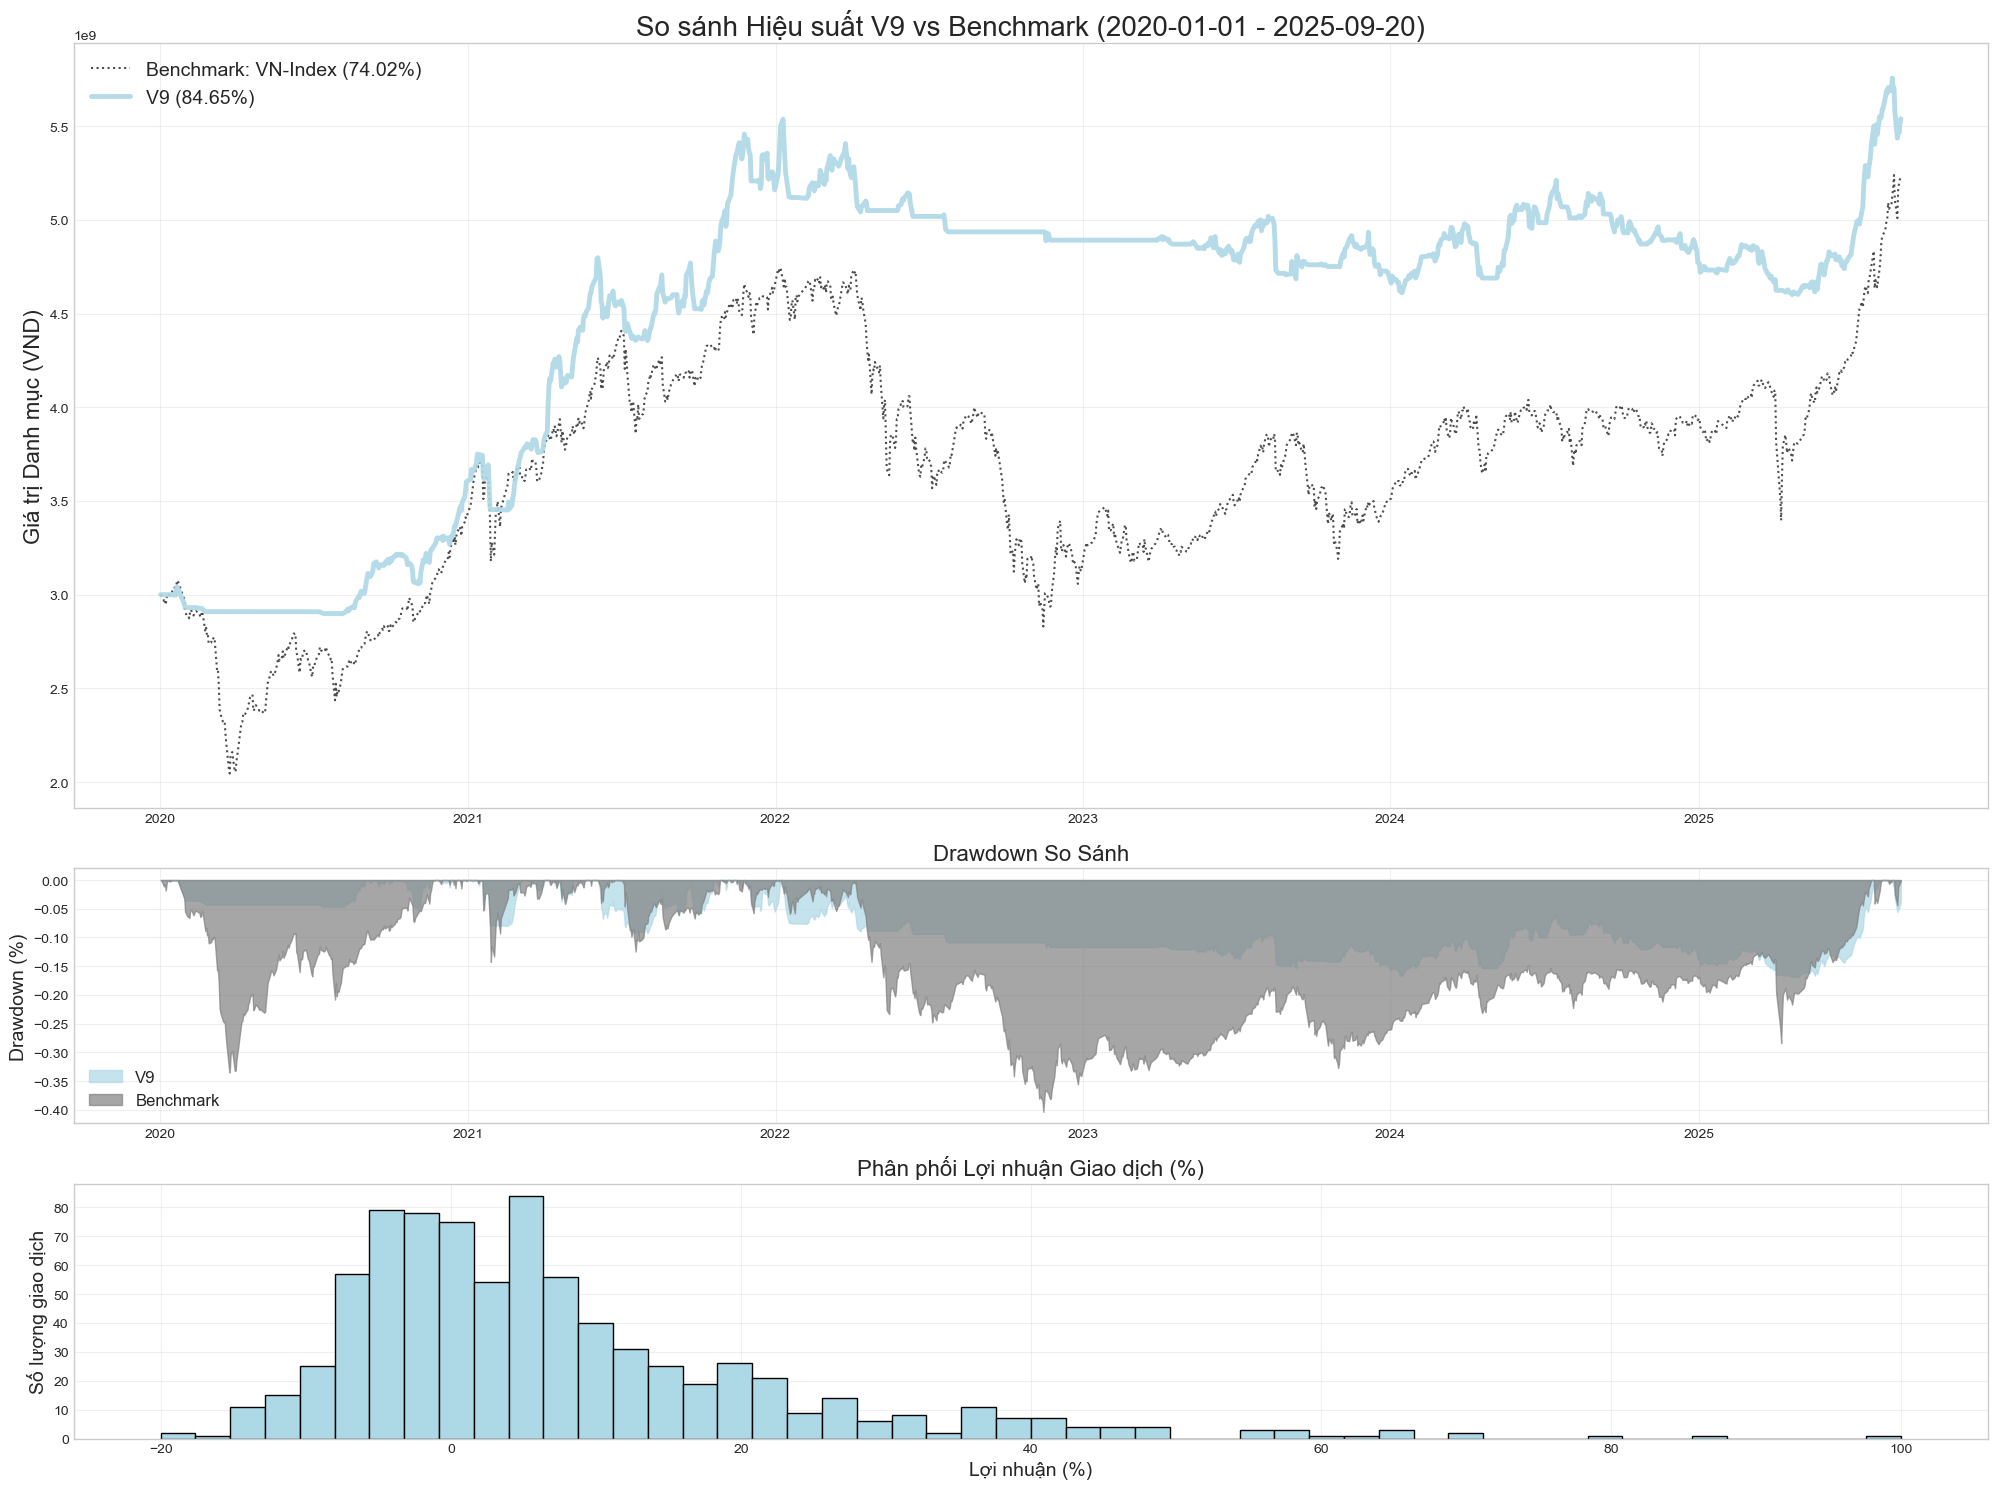

Monte Carlo: 95th Percentile Drawdown = 25.32%
Backtest V9 hoàn tất. Logs đã lưu!


In [40]:
# ===================================================================
# 5. PHÂN TÍCH KẾT QUẢ
# ===================================================================
if not enhanced_metrics_v9:
    print("Không có giao dịch nào được thực hiện. Vui lòng kiểm tra dữ liệu hoặc điều kiện screener.")
else:
    metrics_df = pd.DataFrame({
        'Strategy': ['VN-Index Benchmark', 'V9'],
        'Total Return': [f"{metrics_benchmark['Total Return']:.2%}", f"{enhanced_metrics_v9['Total Return']:.2%}"],
        'Sharpe Ratio': [f"{metrics_benchmark['Sharpe Ratio (Annualized)']:.2f}", f"{enhanced_metrics_v9['Sharpe Ratio']:.2f}"],
        'Max Drawdown': [f"{metrics_benchmark['Max Drawdown']:.2%}", f"{enhanced_metrics_v9['Max Drawdown']:.2%}"],
        'Calmar Ratio': [f"{metrics_benchmark['Calmar Ratio']:.2f}", f"{enhanced_metrics_v9['Calmar Ratio']:.2f}"],
        'Win Rate': ['N/A', f"{enhanced_metrics_v9['Win Rate']:.2%}"],
        'Avg Holding Days': ['N/A', f"{enhanced_metrics_v9['Avg Holding Days']:.1f}"],
        'Profit Factor': ['N/A', f"{enhanced_metrics_v9['Profit Factor']:.2f}"],
        'Max Consec Losses': ['N/A', enhanced_metrics_v9['Max Consec Losses']]
    })
    print("\n--- Bảng So sánh Metrics Mở Rộng ---")
    print(metrics_df.to_string(index=False))

    # Trực quan hóa
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), height_ratios=[3, 1, 1])

    # Equity curve
    ax1.plot(benchmark_performance.index, benchmark_performance, 
             label=f"Benchmark: VN-Index ({metrics_benchmark['Total Return']:.2%})", 
             linestyle=':', color='black', alpha=0.7)
    ax1.plot(performance_v9.index, performance_v9['Portfolio Value'], 
             label=f"V9 ({enhanced_metrics_v9['Total Return']:.2%})",
             linewidth=3.5, color='lightblue', alpha=0.9)
    ax1.set_title(f"So sánh Hiệu suất V9 vs Benchmark ({TEST_START_DATE} - {TEST_END_DATE})", fontsize=20)
    ax1.set_ylabel("Giá trị Danh mục (VND)", fontsize=16)
    ax1.legend(fontsize=14, loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Drawdown
    drawdown_v9 = (performance_v9['Portfolio Value'] - performance_v9['Portfolio Value'].cummax()) / performance_v9['Portfolio Value'].cummax()
    drawdown_bench = (benchmark_performance - benchmark_performance.cummax()) / benchmark_performance.cummax()
    ax2.fill_between(performance_v9.index, drawdown_v9, 0, color='lightblue', alpha=0.7, label='V9')
    ax2.fill_between(benchmark_performance.index, drawdown_bench, 0, color='gray', alpha=0.7, label='Benchmark')
    ax2.set_title('Drawdown So Sánh', fontsize=16)
    ax2.set_ylabel('Drawdown (%)', fontsize=14)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Trade return distribution
    trade_returns = [(t['exit_price'] - t['entry_price']) / t['entry_price'] * 100 for t in trades]
    ax3.hist(trade_returns, bins=50, color='lightblue', edgecolor='black')
    ax3.set_title('Phân phối Lợi nhuận Giao dịch (%)', fontsize=16)
    ax3.set_xlabel('Lợi nhuận (%)', fontsize=14)
    ax3.set_ylabel('Số lượng giao dịch', fontsize=14)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Monte Carlo Simulation
    daily_returns = performance_v9['Portfolio Value'].pct_change().dropna()
    simulations = []
    for _ in range(1000):
        sim_returns = np.random.choice(daily_returns, size=252, replace=True)
        sim_path = np.cumprod(1 + sim_returns)
        simulations.append(sim_path)
    sim_drawdowns = [max((np.max(sim) - sim) / np.max(sim)) for sim in simulations]
    print(f"Monte Carlo: 95th Percentile Drawdown = {np.percentile(sim_drawdowns, 95):.2%}")

print("Backtest V9 hoàn tất. Logs đã lưu!")

V12 có profit vault

In [41]:
# ===================================================================
# 4. THIẾT LẬP & THỰC THI BACKTEST
# ===================================================================
TEST_START_DATE = '2020-01-01'
TEST_END_DATE = '2025-09-20'
INITIAL_CAPITAL = 3_000_000_000
BASE_CAPITAL = 3_000_000_000

print(f"--- Bắt đầu chạy Backtest V9 từ {TEST_START_DATE} đến {TEST_END_DATE} ---")
print("Đang tính toán Benchmark: VN-Index...")
benchmark_performance = calculate_benchmark(df, TEST_START_DATE, TEST_END_DATE, INITIAL_CAPITAL)
metrics_benchmark = calculate_metrics(benchmark_performance)

print("Đang chạy Backtest V9...")
# Tính toán trước các chỉ báo
df = precompute_technical_indicators_vectorized(df)
performance_v9, enhanced_metrics_v9, trades = backtest_engine_v12_profit_vault(
    df, 
    apply_enhanced_screener_v12_sideway_soft,
    TEST_START_DATE, 
    TEST_END_DATE,
    INITIAL_CAPITAL, 
    BASE_CAPITAL,
    commission_buy=0.001,
    commission_sell_base=0.001,
    tax_sell=0.001,
    trade_limit_pct=0.11,
    max_investment_per_trade_pct=0.15,
    max_open_positions=8,
    min_volume_ma20=200000,
    lot_size=100,
    vol_window=20,
    liquidity_threshold=0.1,
    entry_mode='close',
    atr_multiplier=1.5,
    trailing_stop_pct=0.05,
    partial_profit_pct=0.4,
    min_holding_days=3,
    pyramid_limit=1
)

--- Bắt đầu chạy Backtest V9 từ 2020-01-01 đến 2025-09-20 ---
Đang tính toán Benchmark: VN-Index...
Đang chạy Backtest V9...
Đang tính toán các chỉ báo kỹ thuật...
Starting dynamic backtest V12 with market phase adaptation...
Entry mode: close
Data preparation completed in 1.29s
Đang tạo pivot tables...
Pivot tables created in 14.46s
Starting main backtest loop for 1413 dates...
Processing date 1/1413 (0.1%)
Không có cổ phiếu nào được chọn vào ngày 2020-01-02 00:00:00
Watchlist 2020-01-02 00:00:00: []
Không có cổ phiếu nào được chọn vào ngày 2020-01-03 00:00:00
Watchlist 2020-01-03 00:00:00: []
Không có cổ phiếu nào được chọn vào ngày 2020-01-06 00:00:00
Watchlist 2020-01-06 00:00:00: []
Không có cổ phiếu nào được chọn vào ngày 2020-01-07 00:00:00
Watchlist 2020-01-07 00:00:00: []
Không có cổ phiếu nào được chọn vào ngày 2020-01-08 00:00:00
Watchlist 2020-01-08 00:00:00: []
Không có cổ phiếu nào được chọn vào ngày 2020-01-09 00:00:00
Watchlist 2020-01-09 00:00:00: []
Không có cổ phiếu 


--- Bảng So sánh Metrics Mở Rộng ---
          Strategy Total Return Sharpe Ratio Max Drawdown Calmar Ratio Win Rate Avg Holding Days Profit Factor Max Consec Losses
VN-Index Benchmark       74.02%         0.59       40.34%         0.26      N/A              N/A           N/A               N/A
                V9       78.85%         1.16       12.36%         0.88   61.22%             15.8          1.50                13


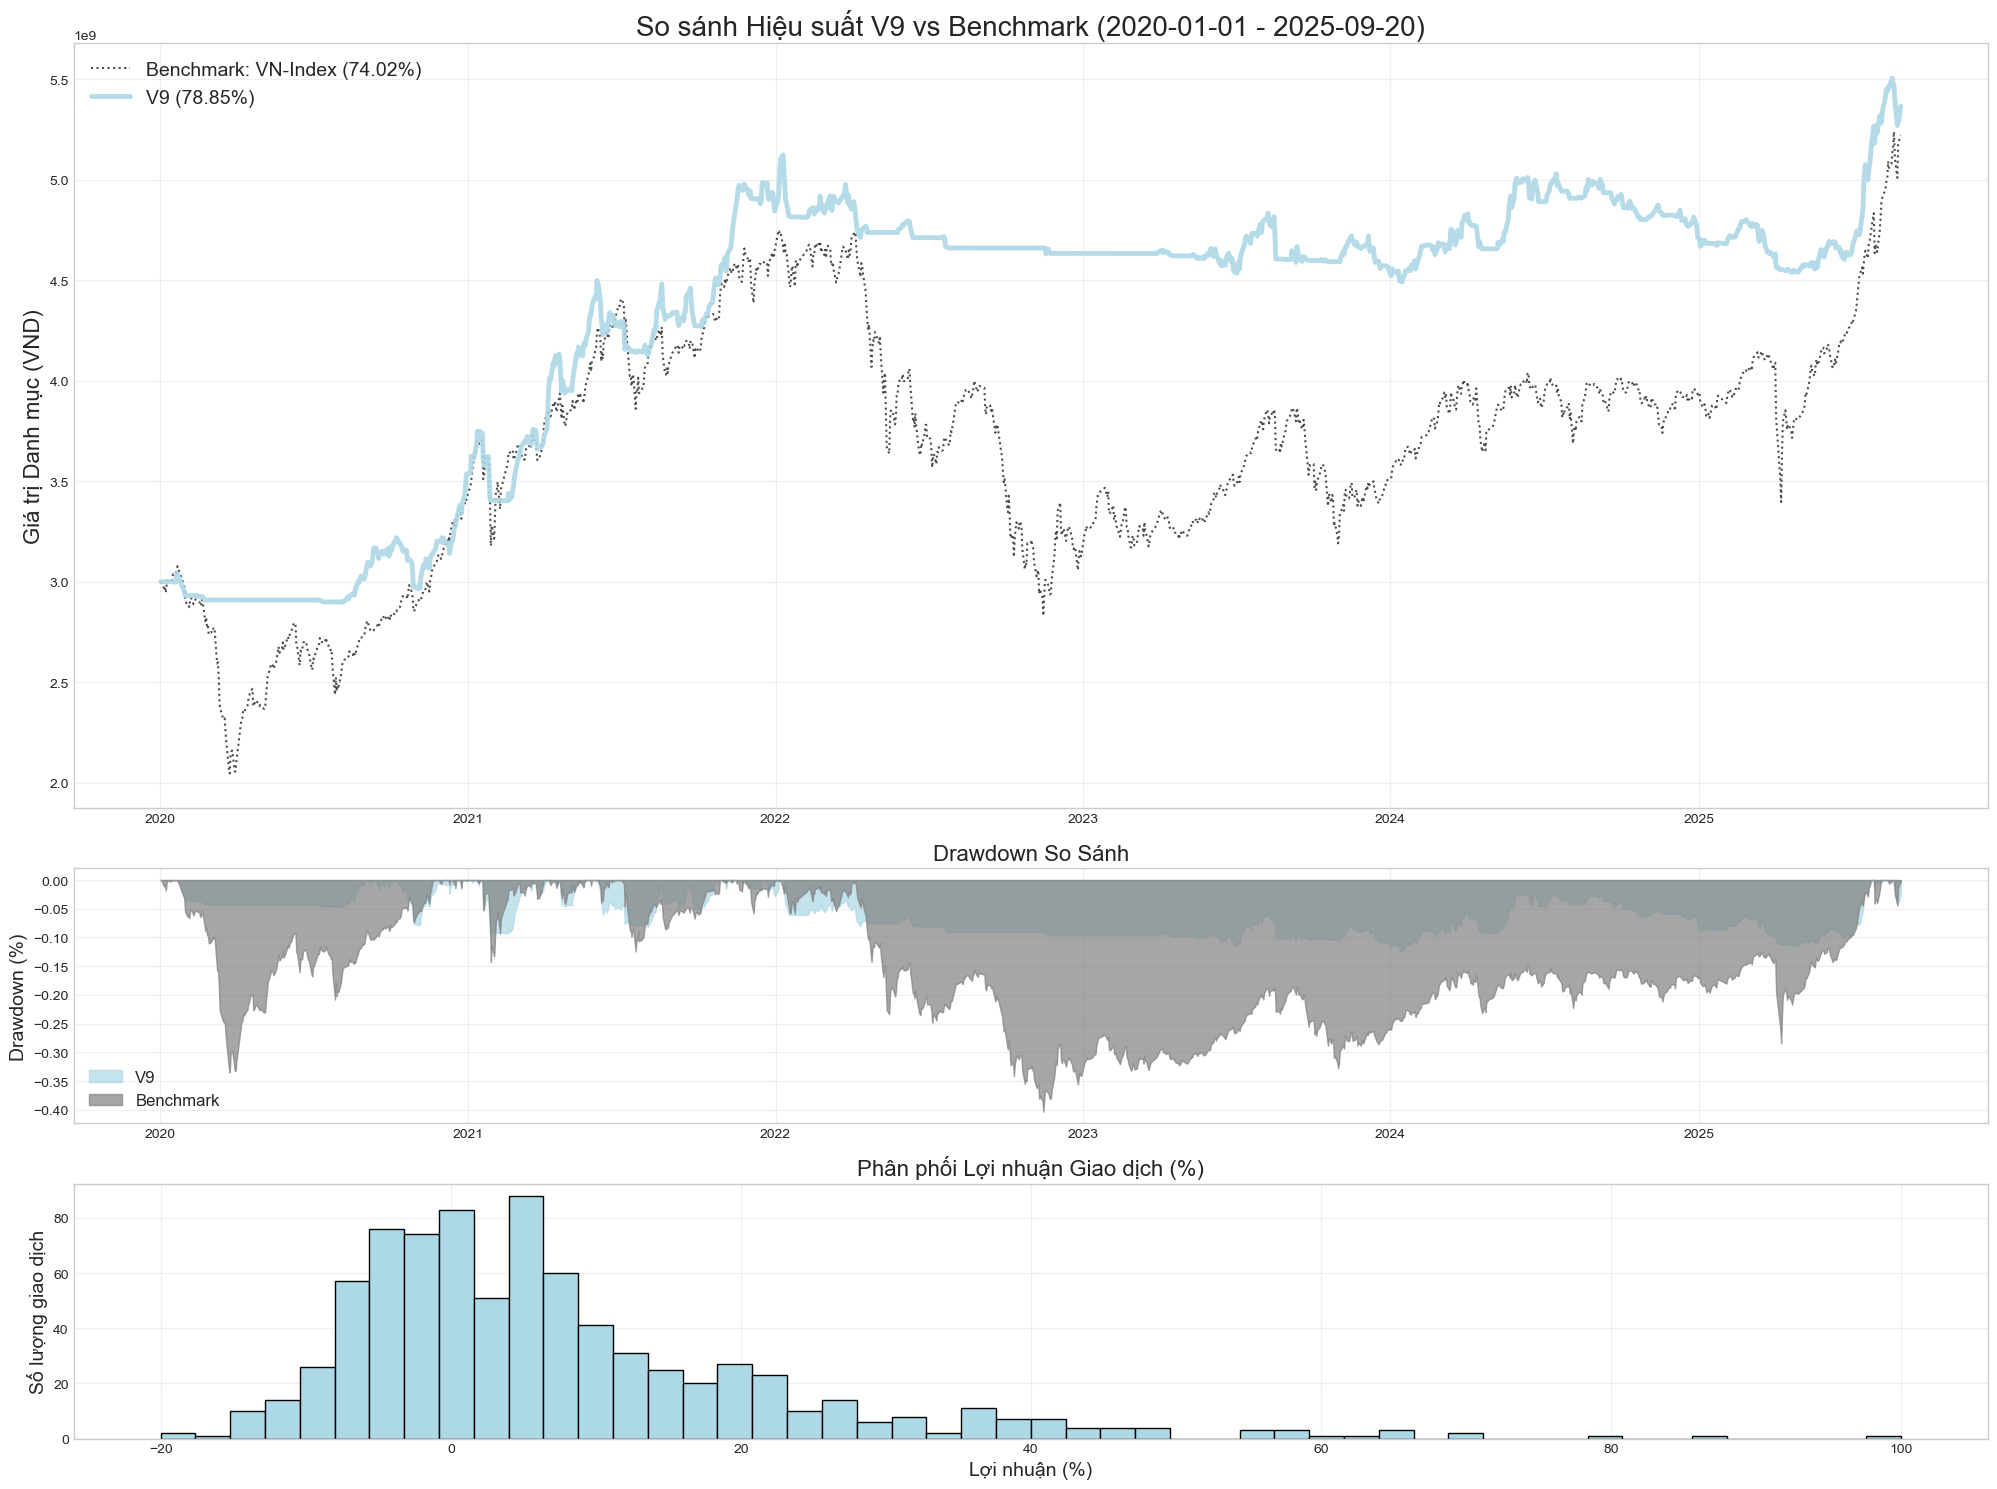

Monte Carlo: 95th Percentile Drawdown = 23.92%
Backtest V9 hoàn tất. Logs đã lưu!


In [42]:
# ===================================================================
# 5. PHÂN TÍCH KẾT QUẢ
# ===================================================================
if not enhanced_metrics_v9:
    print("Không có giao dịch nào được thực hiện. Vui lòng kiểm tra dữ liệu hoặc điều kiện screener.")
else:
    metrics_df = pd.DataFrame({
        'Strategy': ['VN-Index Benchmark', 'V9'],
        'Total Return': [f"{metrics_benchmark['Total Return']:.2%}", f"{enhanced_metrics_v9['Total Return']:.2%}"],
        'Sharpe Ratio': [f"{metrics_benchmark['Sharpe Ratio (Annualized)']:.2f}", f"{enhanced_metrics_v9['Sharpe Ratio']:.2f}"],
        'Max Drawdown': [f"{metrics_benchmark['Max Drawdown']:.2%}", f"{enhanced_metrics_v9['Max Drawdown']:.2%}"],
        'Calmar Ratio': [f"{metrics_benchmark['Calmar Ratio']:.2f}", f"{enhanced_metrics_v9['Calmar Ratio']:.2f}"],
        'Win Rate': ['N/A', f"{enhanced_metrics_v9['Win Rate']:.2%}"],
        'Avg Holding Days': ['N/A', f"{enhanced_metrics_v9['Avg Holding Days']:.1f}"],
        'Profit Factor': ['N/A', f"{enhanced_metrics_v9['Profit Factor']:.2f}"],
        'Max Consec Losses': ['N/A', enhanced_metrics_v9['Max Consec Losses']]
    })
    print("\n--- Bảng So sánh Metrics Mở Rộng ---")
    print(metrics_df.to_string(index=False))

    # Trực quan hóa
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), height_ratios=[3, 1, 1])

    # Equity curve
    ax1.plot(benchmark_performance.index, benchmark_performance, 
             label=f"Benchmark: VN-Index ({metrics_benchmark['Total Return']:.2%})", 
             linestyle=':', color='black', alpha=0.7)
    ax1.plot(performance_v9.index, performance_v9['Portfolio Value'], 
             label=f"V9 ({enhanced_metrics_v9['Total Return']:.2%})",
             linewidth=3.5, color='lightblue', alpha=0.9)
    ax1.set_title(f"So sánh Hiệu suất V9 vs Benchmark ({TEST_START_DATE} - {TEST_END_DATE})", fontsize=20)
    ax1.set_ylabel("Giá trị Danh mục (VND)", fontsize=16)
    ax1.legend(fontsize=14, loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Drawdown
    drawdown_v9 = (performance_v9['Portfolio Value'] - performance_v9['Portfolio Value'].cummax()) / performance_v9['Portfolio Value'].cummax()
    drawdown_bench = (benchmark_performance - benchmark_performance.cummax()) / benchmark_performance.cummax()
    ax2.fill_between(performance_v9.index, drawdown_v9, 0, color='lightblue', alpha=0.7, label='V9')
    ax2.fill_between(benchmark_performance.index, drawdown_bench, 0, color='gray', alpha=0.7, label='Benchmark')
    ax2.set_title('Drawdown So Sánh', fontsize=16)
    ax2.set_ylabel('Drawdown (%)', fontsize=14)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Trade return distribution
    trade_returns = [(t['exit_price'] - t['entry_price']) / t['entry_price'] * 100 for t in trades]
    ax3.hist(trade_returns, bins=50, color='lightblue', edgecolor='black')
    ax3.set_title('Phân phối Lợi nhuận Giao dịch (%)', fontsize=16)
    ax3.set_xlabel('Lợi nhuận (%)', fontsize=14)
    ax3.set_ylabel('Số lượng giao dịch', fontsize=14)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Monte Carlo Simulation
    daily_returns = performance_v9['Portfolio Value'].pct_change().dropna()
    simulations = []
    for _ in range(1000):
        sim_returns = np.random.choice(daily_returns, size=252, replace=True)
        sim_path = np.cumprod(1 + sim_returns)
        simulations.append(sim_path)
    sim_drawdowns = [max((np.max(sim) - sim) / np.max(sim)) for sim in simulations]
    print(f"Monte Carlo: 95th Percentile Drawdown = {np.percentile(sim_drawdowns, 95):.2%}")

print("Backtest V9 hoàn tất. Logs đã lưu!")